In [1]:
import torch

In [2]:
!pip install opendatasets --upgrade --quiet

### Downloading Data

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/kvpratama/pokemon-images-dataset'
od.download(dataset_url)

100%|██████████| 70.9M/70.9M [00:01<00:00, 51.8MB/s]


In [4]:
import os

DATA_DIR = './pokemon-images-dataset'
print(os.listdir(DATA_DIR))

['pokemon', 'pokemon_jpg']


### Loading and Exploring Data

In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size = 64 #converting image to 64 x 64 pixels for better training
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #normalizing images with mean and std of 0.5

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size), #taking center square of rectangle images
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Denormalizing image tensors and displaying some sample images from training batch

In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=256):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


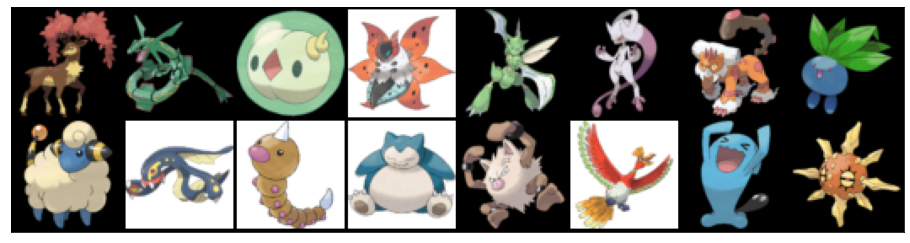

In [11]:
show_batch(train_dl)


### Using a GPU

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

### Discriminator Network

In [15]:
import torch.nn as nn

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
#adding discriminator to GPU
discriminator = to_device(discriminator, device)

### Generator Network

In [18]:
#size of noise vector : 128 pixels
latent_size = 128

In [19]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [20]:
#creating noise and calculating the size of images generated by generator
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)

torch.Size([16, 3, 64, 64])


In [21]:
#adding generator to GPU
generator = to_device(generator, device)

### Training *Discriminator*

In [22]:
def train_discriminator(real_images, opt_d):
    # Clearing discriminator gradients
    opt_d.zero_grad()

    # Passing real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generating fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Passing fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Updating discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

### Training Generator

In [23]:
def train_generator(opt_g):
    # Clearing generator gradients
    opt_g.zero_grad()
    
    # Generating fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Trying to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Updating generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Creating a folder to save generated image via each epoch

In [24]:
from torchvision.utils import save_image

In [25]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [27]:
fixed_latent = torch.randn(16, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


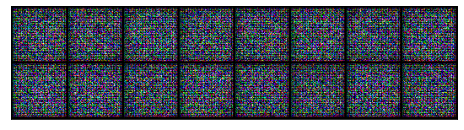

In [28]:
save_samples(0, fixed_latent)

### Full Training Loop

In [29]:
from tqdm import tqdm
import torch.nn.functional as F

In [30]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Creating optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Recording losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Logging losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Saving generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [31]:
lr = 0.0002 #learning rate
epochs = 1000 #number of epochs

In [32]:
history = fit(epochs, lr)

  0%|          | 0/103 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [1/1000], loss_g: 16.3182, loss_d: 0.0948, real_score: 0.9123, fake_score: 0.0000
Saving generated-images-0001.png


100%|██████████| 103/103 [00:09<00:00, 10.81it/s]


Epoch [2/1000], loss_g: 6.6464, loss_d: 0.0158, real_score: 0.9975, fake_score: 0.0131
Saving generated-images-0002.png


100%|██████████| 103/103 [00:09<00:00, 10.87it/s]


Epoch [3/1000], loss_g: 7.0243, loss_d: 0.0065, real_score: 0.9949, fake_score: 0.0013
Saving generated-images-0003.png


100%|██████████| 103/103 [00:09<00:00, 10.78it/s]


Epoch [4/1000], loss_g: 11.4637, loss_d: 0.2560, real_score: 0.9989, fake_score: 0.1999
Saving generated-images-0004.png


100%|██████████| 103/103 [00:09<00:00, 10.74it/s]


Epoch [5/1000], loss_g: 2.6044, loss_d: 0.1706, real_score: 0.8797, fake_score: 0.0387
Saving generated-images-0005.png


100%|██████████| 103/103 [00:09<00:00, 10.73it/s]


Epoch [6/1000], loss_g: 1.9795, loss_d: 0.6798, real_score: 0.6028, fake_score: 0.0302
Saving generated-images-0006.png


100%|██████████| 103/103 [00:09<00:00, 10.72it/s]


Epoch [7/1000], loss_g: 3.9135, loss_d: 0.6069, real_score: 0.9664, fake_score: 0.3142
Saving generated-images-0007.png


100%|██████████| 103/103 [00:09<00:00, 10.71it/s]


Epoch [8/1000], loss_g: 3.5180, loss_d: 1.3992, real_score: 0.9994, fake_score: 0.6775
Saving generated-images-0008.png


100%|██████████| 103/103 [00:09<00:00, 10.71it/s]


Epoch [9/1000], loss_g: 4.1057, loss_d: 0.1633, real_score: 0.9031, fake_score: 0.0529
Saving generated-images-0009.png


100%|██████████| 103/103 [00:09<00:00, 10.69it/s]


Epoch [10/1000], loss_g: 2.6995, loss_d: 0.2369, real_score: 0.9798, fake_score: 0.1804
Saving generated-images-0010.png


100%|██████████| 103/103 [00:09<00:00, 10.66it/s]


Epoch [11/1000], loss_g: 3.7765, loss_d: 0.3218, real_score: 0.9512, fake_score: 0.2157
Saving generated-images-0011.png


100%|██████████| 103/103 [00:09<00:00, 10.58it/s]


Epoch [12/1000], loss_g: 4.4938, loss_d: 0.2191, real_score: 0.8968, fake_score: 0.0952
Saving generated-images-0012.png


100%|██████████| 103/103 [00:09<00:00, 10.68it/s]


Epoch [13/1000], loss_g: 4.0386, loss_d: 0.4303, real_score: 0.9402, fake_score: 0.2769
Saving generated-images-0013.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [14/1000], loss_g: 5.4791, loss_d: 0.1591, real_score: 0.9497, fake_score: 0.0882
Saving generated-images-0014.png


100%|██████████| 103/103 [00:09<00:00, 10.60it/s]


Epoch [15/1000], loss_g: 1.9847, loss_d: 0.3689, real_score: 0.8509, fake_score: 0.1491
Saving generated-images-0015.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [16/1000], loss_g: 1.7704, loss_d: 0.1544, real_score: 0.8880, fake_score: 0.0247
Saving generated-images-0016.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [17/1000], loss_g: 5.9056, loss_d: 0.0725, real_score: 0.9342, fake_score: 0.0038
Saving generated-images-0017.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [18/1000], loss_g: 3.5439, loss_d: 0.6541, real_score: 0.9779, fake_score: 0.3517
Saving generated-images-0018.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [19/1000], loss_g: 6.7621, loss_d: 0.5185, real_score: 0.9322, fake_score: 0.2649
Saving generated-images-0019.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [20/1000], loss_g: 4.6775, loss_d: 0.1960, real_score: 0.9598, fake_score: 0.1380
Saving generated-images-0020.png


100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


Epoch [21/1000], loss_g: 2.5931, loss_d: 0.0977, real_score: 0.9148, fake_score: 0.0071
Saving generated-images-0021.png


100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


Epoch [22/1000], loss_g: 3.2216, loss_d: 0.5030, real_score: 0.7060, fake_score: 0.0064
Saving generated-images-0022.png


100%|██████████| 103/103 [00:09<00:00, 10.60it/s]


Epoch [23/1000], loss_g: 4.1001, loss_d: 0.1300, real_score: 0.9184, fake_score: 0.0392
Saving generated-images-0023.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [24/1000], loss_g: 4.3413, loss_d: 0.4955, real_score: 0.9946, fake_score: 0.3556
Saving generated-images-0024.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [25/1000], loss_g: 3.4976, loss_d: 0.0229, real_score: 0.9833, fake_score: 0.0059
Saving generated-images-0025.png


100%|██████████| 103/103 [00:09<00:00, 10.58it/s]


Epoch [26/1000], loss_g: 5.5453, loss_d: 0.2301, real_score: 0.9624, fake_score: 0.1563
Saving generated-images-0026.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [27/1000], loss_g: 5.7322, loss_d: 3.1450, real_score: 0.1418, fake_score: 0.0015
Saving generated-images-0027.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [28/1000], loss_g: 7.4522, loss_d: 0.2529, real_score: 0.8481, fake_score: 0.0498
Saving generated-images-0028.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [29/1000], loss_g: 0.2910, loss_d: 0.0846, real_score: 0.9850, fake_score: 0.0645
Saving generated-images-0029.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [30/1000], loss_g: 6.7787, loss_d: 0.4041, real_score: 0.9546, fake_score: 0.2492
Saving generated-images-0030.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [31/1000], loss_g: 2.5400, loss_d: 0.0870, real_score: 0.9440, fake_score: 0.0274
Saving generated-images-0031.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [32/1000], loss_g: 4.7433, loss_d: 0.1923, real_score: 0.9320, fake_score: 0.1056
Saving generated-images-0032.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [33/1000], loss_g: 2.8968, loss_d: 1.1962, real_score: 0.9987, fake_score: 0.6684
Saving generated-images-0033.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [34/1000], loss_g: 6.1416, loss_d: 0.5163, real_score: 0.9679, fake_score: 0.3437
Saving generated-images-0034.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [35/1000], loss_g: 6.1892, loss_d: 0.0443, real_score: 0.9788, fake_score: 0.0220
Saving generated-images-0035.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [36/1000], loss_g: 5.7675, loss_d: 1.2077, real_score: 0.9531, fake_score: 0.6350
Saving generated-images-0036.png


100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


Epoch [37/1000], loss_g: 6.0365, loss_d: 0.0634, real_score: 0.9634, fake_score: 0.0248
Saving generated-images-0037.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [38/1000], loss_g: 5.4361, loss_d: 0.1332, real_score: 0.8795, fake_score: 0.0028
Saving generated-images-0038.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [39/1000], loss_g: 7.0063, loss_d: 1.3095, real_score: 0.5154, fake_score: 0.0046
Saving generated-images-0039.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [40/1000], loss_g: 1.7239, loss_d: 0.4100, real_score: 0.9778, fake_score: 0.3038
Saving generated-images-0040.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [41/1000], loss_g: 6.3962, loss_d: 1.3189, real_score: 0.9943, fake_score: 0.6289
Saving generated-images-0041.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [42/1000], loss_g: 6.2496, loss_d: 0.1092, real_score: 0.9685, fake_score: 0.0716
Saving generated-images-0042.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [43/1000], loss_g: 8.8362, loss_d: 0.3540, real_score: 0.9956, fake_score: 0.2640
Saving generated-images-0043.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [44/1000], loss_g: 3.5230, loss_d: 0.0137, real_score: 0.9876, fake_score: 0.0012
Saving generated-images-0044.png


100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


Epoch [45/1000], loss_g: 5.3220, loss_d: 0.3084, real_score: 0.9757, fake_score: 0.2183
Saving generated-images-0045.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [46/1000], loss_g: 7.0150, loss_d: 0.0707, real_score: 0.9340, fake_score: 0.0019
Saving generated-images-0046.png


100%|██████████| 103/103 [00:09<00:00, 10.64it/s]


Epoch [47/1000], loss_g: 5.8822, loss_d: 0.0848, real_score: 0.9202, fake_score: 0.0004
Saving generated-images-0047.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [48/1000], loss_g: 10.7999, loss_d: 0.7493, real_score: 0.5572, fake_score: 0.0000
Saving generated-images-0048.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [49/1000], loss_g: 5.1131, loss_d: 0.1120, real_score: 0.9057, fake_score: 0.0067
Saving generated-images-0049.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [50/1000], loss_g: 6.2123, loss_d: 0.3001, real_score: 0.7683, fake_score: 0.0156
Saving generated-images-0050.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [51/1000], loss_g: 5.8362, loss_d: 0.0506, real_score: 0.9569, fake_score: 0.0056
Saving generated-images-0051.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [52/1000], loss_g: 3.4805, loss_d: 0.0692, real_score: 0.9935, fake_score: 0.0599
Saving generated-images-0052.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [53/1000], loss_g: 6.4181, loss_d: 0.9059, real_score: 0.9315, fake_score: 0.4190
Saving generated-images-0053.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [54/1000], loss_g: 0.1223, loss_d: 0.0625, real_score: 0.9762, fake_score: 0.0365
Saving generated-images-0054.png


100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


Epoch [55/1000], loss_g: 4.6168, loss_d: 0.3957, real_score: 0.9559, fake_score: 0.2751
Saving generated-images-0055.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [56/1000], loss_g: 3.4261, loss_d: 0.4186, real_score: 0.9981, fake_score: 0.2933
Saving generated-images-0056.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [57/1000], loss_g: 2.8305, loss_d: 0.6742, real_score: 0.9459, fake_score: 0.4125
Saving generated-images-0057.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [58/1000], loss_g: 7.0151, loss_d: 0.4712, real_score: 0.9840, fake_score: 0.3394
Saving generated-images-0058.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [59/1000], loss_g: 6.3572, loss_d: 0.3132, real_score: 0.7601, fake_score: 0.0252
Saving generated-images-0059.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [60/1000], loss_g: 4.9467, loss_d: 0.0648, real_score: 0.9765, fake_score: 0.0395
Saving generated-images-0060.png


100%|██████████| 103/103 [00:09<00:00, 10.58it/s]


Epoch [61/1000], loss_g: 4.9852, loss_d: 0.3333, real_score: 0.9971, fake_score: 0.2120
Saving generated-images-0061.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [62/1000], loss_g: 3.8571, loss_d: 0.6009, real_score: 0.8871, fake_score: 0.3351
Saving generated-images-0062.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [63/1000], loss_g: 8.5845, loss_d: 0.0133, real_score: 0.9987, fake_score: 0.0118
Saving generated-images-0063.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [64/1000], loss_g: 10.7630, loss_d: 0.1438, real_score: 0.8786, fake_score: 0.0049
Saving generated-images-0064.png


100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


Epoch [65/1000], loss_g: 5.7929, loss_d: 0.9703, real_score: 0.4952, fake_score: 0.0047
Saving generated-images-0065.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [66/1000], loss_g: 7.9752, loss_d: 0.2324, real_score: 0.8045, fake_score: 0.0007
Saving generated-images-0066.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [67/1000], loss_g: 3.0830, loss_d: 0.0030, real_score: 0.9998, fake_score: 0.0028
Saving generated-images-0067.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [68/1000], loss_g: 8.1719, loss_d: 0.1891, real_score: 0.8374, fake_score: 0.0000
Saving generated-images-0068.png


100%|██████████| 103/103 [00:09<00:00, 10.61it/s]


Epoch [69/1000], loss_g: 3.8514, loss_d: 0.0476, real_score: 0.9853, fake_score: 0.0315
Saving generated-images-0069.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [70/1000], loss_g: 7.6204, loss_d: 0.1238, real_score: 0.9124, fake_score: 0.0107
Saving generated-images-0070.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [71/1000], loss_g: 6.4036, loss_d: 0.0113, real_score: 0.9915, fake_score: 0.0027
Saving generated-images-0071.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [72/1000], loss_g: 9.0370, loss_d: 0.1041, real_score: 0.9537, fake_score: 0.0507
Saving generated-images-0072.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [73/1000], loss_g: 4.5733, loss_d: 0.0180, real_score: 0.9825, fake_score: 0.0001
Saving generated-images-0073.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [74/1000], loss_g: 5.3822, loss_d: 1.2904, real_score: 0.5006, fake_score: 0.0001
Saving generated-images-0074.png


100%|██████████| 103/103 [00:09<00:00, 10.61it/s]


Epoch [75/1000], loss_g: 6.0654, loss_d: 0.0017, real_score: 0.9994, fake_score: 0.0011
Saving generated-images-0075.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [76/1000], loss_g: 8.1444, loss_d: 0.0184, real_score: 0.9821, fake_score: 0.0001
Saving generated-images-0076.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [77/1000], loss_g: 7.4502, loss_d: 1.0832, real_score: 0.9899, fake_score: 0.5318
Saving generated-images-0077.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [78/1000], loss_g: 7.9906, loss_d: 0.0023, real_score: 0.9983, fake_score: 0.0006
Saving generated-images-0078.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [79/1000], loss_g: 2.7546, loss_d: 0.1665, real_score: 0.8837, fake_score: 0.0259
Saving generated-images-0079.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [80/1000], loss_g: 2.2692, loss_d: 0.0556, real_score: 0.9579, fake_score: 0.0106
Saving generated-images-0080.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [81/1000], loss_g: 4.7372, loss_d: 0.0367, real_score: 0.9643, fake_score: 0.0000
Saving generated-images-0081.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [82/1000], loss_g: 9.8615, loss_d: 0.0960, real_score: 0.9168, fake_score: 0.0031
Saving generated-images-0082.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [83/1000], loss_g: 7.6891, loss_d: 0.0341, real_score: 0.9748, fake_score: 0.0083
Saving generated-images-0083.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [84/1000], loss_g: 6.4074, loss_d: 0.0295, real_score: 0.9773, fake_score: 0.0060
Saving generated-images-0084.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [85/1000], loss_g: 5.2974, loss_d: 0.1762, real_score: 0.8542, fake_score: 0.0101
Saving generated-images-0085.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [86/1000], loss_g: 7.8797, loss_d: 0.0063, real_score: 0.9949, fake_score: 0.0012
Saving generated-images-0086.png


100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


Epoch [87/1000], loss_g: 8.5555, loss_d: 0.0702, real_score: 0.9446, fake_score: 0.0103
Saving generated-images-0087.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [88/1000], loss_g: 8.1917, loss_d: 0.1737, real_score: 0.9110, fake_score: 0.0600
Saving generated-images-0088.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [89/1000], loss_g: 7.8254, loss_d: 0.0394, real_score: 0.9751, fake_score: 0.0137
Saving generated-images-0089.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [90/1000], loss_g: 5.8626, loss_d: 0.0240, real_score: 0.9780, fake_score: 0.0013
Saving generated-images-0090.png


100%|██████████| 103/103 [00:09<00:00, 10.58it/s]


Epoch [91/1000], loss_g: 2.7796, loss_d: 0.0102, real_score: 0.9947, fake_score: 0.0049
Saving generated-images-0091.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [92/1000], loss_g: 3.6933, loss_d: 0.1204, real_score: 0.9951, fake_score: 0.0977
Saving generated-images-0092.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [93/1000], loss_g: 2.8626, loss_d: 0.0058, real_score: 0.9944, fake_score: 0.0002
Saving generated-images-0093.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [94/1000], loss_g: 9.1940, loss_d: 0.0114, real_score: 0.9964, fake_score: 0.0077
Saving generated-images-0094.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [95/1000], loss_g: 7.2247, loss_d: 0.4095, real_score: 0.9987, fake_score: 0.2851
Saving generated-images-0095.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [96/1000], loss_g: 8.9150, loss_d: 0.0094, real_score: 0.9910, fake_score: 0.0004
Saving generated-images-0096.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [97/1000], loss_g: 13.1623, loss_d: 0.5653, real_score: 0.9937, fake_score: 0.3695
Saving generated-images-0097.png


100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


Epoch [98/1000], loss_g: 3.7351, loss_d: 0.0146, real_score: 0.9991, fake_score: 0.0132
Saving generated-images-0098.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [99/1000], loss_g: 5.6057, loss_d: 0.2699, real_score: 0.8305, fake_score: 0.0003
Saving generated-images-0099.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [100/1000], loss_g: 3.7477, loss_d: 0.0220, real_score: 0.9941, fake_score: 0.0157
Saving generated-images-0100.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [101/1000], loss_g: 10.3380, loss_d: 0.0408, real_score: 0.9683, fake_score: 0.0082
Saving generated-images-0101.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [102/1000], loss_g: 5.7054, loss_d: 0.4017, real_score: 0.7494, fake_score: 0.0004
Saving generated-images-0102.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [103/1000], loss_g: 12.8919, loss_d: 0.0030, real_score: 0.9998, fake_score: 0.0028
Saving generated-images-0103.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [104/1000], loss_g: 7.9674, loss_d: 0.0512, real_score: 0.9785, fake_score: 0.0276
Saving generated-images-0104.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [105/1000], loss_g: 4.4469, loss_d: 0.0706, real_score: 0.9981, fake_score: 0.0523
Saving generated-images-0105.png


100%|██████████| 103/103 [00:09<00:00, 10.58it/s]


Epoch [106/1000], loss_g: 9.8605, loss_d: 0.1080, real_score: 0.9035, fake_score: 0.0003
Saving generated-images-0106.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [107/1000], loss_g: 4.1339, loss_d: 0.0089, real_score: 0.9919, fake_score: 0.0007
Saving generated-images-0107.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [108/1000], loss_g: 9.4117, loss_d: 0.7985, real_score: 0.8429, fake_score: 0.2536
Saving generated-images-0108.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [109/1000], loss_g: 5.7947, loss_d: 0.0029, real_score: 0.9997, fake_score: 0.0025
Saving generated-images-0109.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [110/1000], loss_g: 8.3773, loss_d: 0.0178, real_score: 0.9832, fake_score: 0.0006
Saving generated-images-0110.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [111/1000], loss_g: 9.1411, loss_d: 0.2477, real_score: 0.8203, fake_score: 0.0000
Saving generated-images-0111.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [112/1000], loss_g: 8.6538, loss_d: 0.0221, real_score: 0.9988, fake_score: 0.0202
Saving generated-images-0112.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [113/1000], loss_g: 8.6662, loss_d: 0.0295, real_score: 0.9723, fake_score: 0.0010
Saving generated-images-0113.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [114/1000], loss_g: 4.5379, loss_d: 0.1429, real_score: 0.9984, fake_score: 0.1065
Saving generated-images-0114.png


100%|██████████| 103/103 [00:09<00:00, 10.62it/s]


Epoch [115/1000], loss_g: 11.9134, loss_d: 0.0494, real_score: 0.9996, fake_score: 0.0444
Saving generated-images-0115.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [116/1000], loss_g: 4.4952, loss_d: 0.0856, real_score: 0.9351, fake_score: 0.0146
Saving generated-images-0116.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [117/1000], loss_g: 8.4616, loss_d: 0.0206, real_score: 0.9799, fake_score: 0.0002
Saving generated-images-0117.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [118/1000], loss_g: 3.3271, loss_d: 0.0469, real_score: 0.9720, fake_score: 0.0175
Saving generated-images-0118.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [119/1000], loss_g: 5.9049, loss_d: 0.0122, real_score: 0.9947, fake_score: 0.0068
Saving generated-images-0119.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [120/1000], loss_g: 8.4687, loss_d: 0.0104, real_score: 0.9899, fake_score: 0.0002
Saving generated-images-0120.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [121/1000], loss_g: 9.0924, loss_d: 0.0497, real_score: 0.9883, fake_score: 0.0356
Saving generated-images-0121.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [122/1000], loss_g: 4.6193, loss_d: 0.0317, real_score: 0.9932, fake_score: 0.0238
Saving generated-images-0122.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [123/1000], loss_g: 7.2017, loss_d: 0.0687, real_score: 0.9968, fake_score: 0.0573
Saving generated-images-0123.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [124/1000], loss_g: 9.2145, loss_d: 0.3885, real_score: 0.9941, fake_score: 0.2314
Saving generated-images-0124.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [125/1000], loss_g: 12.3799, loss_d: 0.1807, real_score: 0.8482, fake_score: 0.0002
Saving generated-images-0125.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [126/1000], loss_g: 8.9232, loss_d: 0.0027, real_score: 0.9988, fake_score: 0.0015
Saving generated-images-0126.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [127/1000], loss_g: 10.7491, loss_d: 0.8760, real_score: 0.9934, fake_score: 0.4274
Saving generated-images-0127.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [128/1000], loss_g: 12.8750, loss_d: 0.4881, real_score: 0.9992, fake_score: 0.2896
Saving generated-images-0128.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [129/1000], loss_g: 11.8743, loss_d: 0.0599, real_score: 0.9453, fake_score: 0.0002
Saving generated-images-0129.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [130/1000], loss_g: 6.1910, loss_d: 0.0794, real_score: 0.9348, fake_score: 0.0001
Saving generated-images-0130.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [131/1000], loss_g: 7.3204, loss_d: 0.0098, real_score: 0.9982, fake_score: 0.0079
Saving generated-images-0131.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [132/1000], loss_g: 9.0355, loss_d: 0.0030, real_score: 0.9970, fake_score: 0.0000
Saving generated-images-0132.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [133/1000], loss_g: 7.8781, loss_d: 0.1848, real_score: 0.9987, fake_score: 0.1479
Saving generated-images-0133.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [134/1000], loss_g: 9.3270, loss_d: 0.2063, real_score: 0.9701, fake_score: 0.1419
Saving generated-images-0134.png


100%|██████████| 103/103 [00:09<00:00, 10.58it/s]


Epoch [135/1000], loss_g: 6.9713, loss_d: 0.0278, real_score: 0.9733, fake_score: 0.0004
Saving generated-images-0135.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [136/1000], loss_g: 1.5386, loss_d: 0.0115, real_score: 0.9950, fake_score: 0.0063
Saving generated-images-0136.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [137/1000], loss_g: 6.0108, loss_d: 0.0215, real_score: 0.9866, fake_score: 0.0076
Saving generated-images-0137.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [138/1000], loss_g: 3.2953, loss_d: 0.0453, real_score: 0.9889, fake_score: 0.0315
Saving generated-images-0138.png


100%|██████████| 103/103 [00:09<00:00, 10.60it/s]


Epoch [139/1000], loss_g: 5.2312, loss_d: 0.0454, real_score: 0.9586, fake_score: 0.0002
Saving generated-images-0139.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [140/1000], loss_g: 12.1996, loss_d: 0.0691, real_score: 0.9408, fake_score: 0.0002
Saving generated-images-0140.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [141/1000], loss_g: 5.4462, loss_d: 0.0066, real_score: 0.9990, fake_score: 0.0054
Saving generated-images-0141.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [142/1000], loss_g: 16.7146, loss_d: 0.3283, real_score: 0.9956, fake_score: 0.1747
Saving generated-images-0142.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [143/1000], loss_g: 16.0111, loss_d: 0.0583, real_score: 0.9462, fake_score: 0.0000
Saving generated-images-0143.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [144/1000], loss_g: 8.0915, loss_d: 0.0208, real_score: 0.9809, fake_score: 0.0007
Saving generated-images-0144.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [145/1000], loss_g: 3.6032, loss_d: 0.0192, real_score: 0.9988, fake_score: 0.0175
Saving generated-images-0145.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [146/1000], loss_g: 5.7750, loss_d: 0.0017, real_score: 0.9995, fake_score: 0.0012
Saving generated-images-0146.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [147/1000], loss_g: 10.4683, loss_d: 0.0129, real_score: 0.9875, fake_score: 0.0002
Saving generated-images-0147.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [148/1000], loss_g: 7.0396, loss_d: 0.0660, real_score: 0.9958, fake_score: 0.0517
Saving generated-images-0148.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [149/1000], loss_g: 8.5412, loss_d: 0.0273, real_score: 0.9966, fake_score: 0.0233
Saving generated-images-0149.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [150/1000], loss_g: 9.7192, loss_d: 0.0187, real_score: 0.9989, fake_score: 0.0167
Saving generated-images-0150.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [151/1000], loss_g: 8.2147, loss_d: 0.0104, real_score: 0.9988, fake_score: 0.0091
Saving generated-images-0151.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [152/1000], loss_g: 8.1752, loss_d: 0.0668, real_score: 0.9451, fake_score: 0.0043
Saving generated-images-0152.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [153/1000], loss_g: 11.3712, loss_d: 0.0310, real_score: 0.9939, fake_score: 0.0206
Saving generated-images-0153.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [154/1000], loss_g: 5.8237, loss_d: 0.0876, real_score: 0.9382, fake_score: 0.0177
Saving generated-images-0154.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [155/1000], loss_g: 7.2505, loss_d: 0.0073, real_score: 0.9964, fake_score: 0.0037
Saving generated-images-0155.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [156/1000], loss_g: 3.4790, loss_d: 0.0648, real_score: 0.9990, fake_score: 0.0528
Saving generated-images-0156.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [157/1000], loss_g: 6.4394, loss_d: 0.0010, real_score: 0.9998, fake_score: 0.0009
Saving generated-images-0157.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [158/1000], loss_g: 8.9728, loss_d: 0.2888, real_score: 0.9852, fake_score: 0.1505
Saving generated-images-0158.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [159/1000], loss_g: 9.3647, loss_d: 0.0871, real_score: 0.9216, fake_score: 0.0003
Saving generated-images-0159.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [160/1000], loss_g: 4.0924, loss_d: 0.1500, real_score: 0.8671, fake_score: 0.0001
Saving generated-images-0160.png


100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


Epoch [161/1000], loss_g: 6.1200, loss_d: 0.0052, real_score: 0.9988, fake_score: 0.0040
Saving generated-images-0161.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [162/1000], loss_g: 11.0065, loss_d: 0.0301, real_score: 0.9712, fake_score: 0.0003
Saving generated-images-0162.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [163/1000], loss_g: 4.3399, loss_d: 0.0028, real_score: 0.9974, fake_score: 0.0002
Saving generated-images-0163.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [164/1000], loss_g: 13.2926, loss_d: 0.0021, real_score: 0.9980, fake_score: 0.0001
Saving generated-images-0164.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [165/1000], loss_g: 5.7599, loss_d: 0.0018, real_score: 1.0000, fake_score: 0.0018
Saving generated-images-0165.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [166/1000], loss_g: 8.2907, loss_d: 0.0181, real_score: 0.9969, fake_score: 0.0146
Saving generated-images-0166.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [167/1000], loss_g: 11.2647, loss_d: 0.3253, real_score: 0.9999, fake_score: 0.2343
Saving generated-images-0167.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [168/1000], loss_g: 9.6245, loss_d: 0.0029, real_score: 0.9989, fake_score: 0.0018
Saving generated-images-0168.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [169/1000], loss_g: 10.8500, loss_d: 0.0008, real_score: 0.9994, fake_score: 0.0002
Saving generated-images-0169.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [170/1000], loss_g: 5.9776, loss_d: 0.0032, real_score: 0.9971, fake_score: 0.0003
Saving generated-images-0170.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [171/1000], loss_g: 7.6147, loss_d: 0.0023, real_score: 0.9989, fake_score: 0.0012
Saving generated-images-0171.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [172/1000], loss_g: 11.3520, loss_d: 0.0511, real_score: 0.9538, fake_score: 0.0002
Saving generated-images-0172.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [173/1000], loss_g: 9.8326, loss_d: 0.0625, real_score: 0.9990, fake_score: 0.0539
Saving generated-images-0173.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [174/1000], loss_g: 10.1597, loss_d: 0.0526, real_score: 0.9845, fake_score: 0.0334
Saving generated-images-0174.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [175/1000], loss_g: 6.9459, loss_d: 0.0093, real_score: 0.9986, fake_score: 0.0077
Saving generated-images-0175.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [176/1000], loss_g: 6.0194, loss_d: 0.0676, real_score: 0.9984, fake_score: 0.0576
Saving generated-images-0176.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [177/1000], loss_g: 8.0069, loss_d: 0.0282, real_score: 0.9971, fake_score: 0.0241
Saving generated-images-0177.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [178/1000], loss_g: 14.3648, loss_d: 0.0125, real_score: 0.9878, fake_score: 0.0000
Saving generated-images-0178.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [179/1000], loss_g: 6.5044, loss_d: 0.0460, real_score: 0.9566, fake_score: 0.0001
Saving generated-images-0179.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [180/1000], loss_g: 4.5648, loss_d: 0.0088, real_score: 1.0000, fake_score: 0.0087
Saving generated-images-0180.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [181/1000], loss_g: 14.5786, loss_d: 0.0467, real_score: 0.9552, fake_score: 0.0000
Saving generated-images-0181.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [182/1000], loss_g: 6.4347, loss_d: 0.0135, real_score: 0.9868, fake_score: 0.0000
Saving generated-images-0182.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [183/1000], loss_g: 10.5017, loss_d: 0.0034, real_score: 0.9975, fake_score: 0.0009
Saving generated-images-0183.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [184/1000], loss_g: 10.0452, loss_d: 0.0221, real_score: 0.9941, fake_score: 0.0157
Saving generated-images-0184.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [185/1000], loss_g: 7.4951, loss_d: 0.0137, real_score: 0.9970, fake_score: 0.0101
Saving generated-images-0185.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [186/1000], loss_g: 17.0617, loss_d: 0.0464, real_score: 0.9562, fake_score: 0.0000
Saving generated-images-0186.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [187/1000], loss_g: 8.6293, loss_d: 0.0012, real_score: 0.9991, fake_score: 0.0003
Saving generated-images-0187.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [188/1000], loss_g: 10.2584, loss_d: 0.0422, real_score: 0.9977, fake_score: 0.0359
Saving generated-images-0188.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [189/1000], loss_g: 3.1469, loss_d: 0.0021, real_score: 0.9980, fake_score: 0.0000
Saving generated-images-0189.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [190/1000], loss_g: 7.2594, loss_d: 0.0038, real_score: 0.9996, fake_score: 0.0033
Saving generated-images-0190.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [191/1000], loss_g: 9.3269, loss_d: 0.0128, real_score: 0.9977, fake_score: 0.0103
Saving generated-images-0191.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [192/1000], loss_g: 12.1048, loss_d: 0.6373, real_score: 0.6988, fake_score: 0.0022
Saving generated-images-0192.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [193/1000], loss_g: 7.5546, loss_d: 0.1177, real_score: 0.9164, fake_score: 0.0030
Saving generated-images-0193.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [194/1000], loss_g: 15.8173, loss_d: 0.0796, real_score: 0.9327, fake_score: 0.0005
Saving generated-images-0194.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [195/1000], loss_g: 5.1632, loss_d: 0.0034, real_score: 0.9966, fake_score: 0.0000
Saving generated-images-0195.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [196/1000], loss_g: 8.5642, loss_d: 0.0312, real_score: 0.9998, fake_score: 0.0290
Saving generated-images-0196.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [197/1000], loss_g: 13.6865, loss_d: 0.0011, real_score: 0.9990, fake_score: 0.0002
Saving generated-images-0197.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [198/1000], loss_g: 9.9456, loss_d: 0.0174, real_score: 0.9838, fake_score: 0.0004
Saving generated-images-0198.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [199/1000], loss_g: 9.3376, loss_d: 0.0004, real_score: 0.9998, fake_score: 0.0002
Saving generated-images-0199.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [200/1000], loss_g: 9.9569, loss_d: 0.0278, real_score: 0.9979, fake_score: 0.0240
Saving generated-images-0200.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [201/1000], loss_g: 14.8623, loss_d: 0.0005, real_score: 0.9996, fake_score: 0.0001
Saving generated-images-0201.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [202/1000], loss_g: 8.9428, loss_d: 0.0055, real_score: 0.9947, fake_score: 0.0001
Saving generated-images-0202.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [203/1000], loss_g: 10.4943, loss_d: 0.0651, real_score: 0.9450, fake_score: 0.0000
Saving generated-images-0203.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [204/1000], loss_g: 10.5467, loss_d: 0.0616, real_score: 0.9999, fake_score: 0.0552
Saving generated-images-0204.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [205/1000], loss_g: 13.8068, loss_d: 0.0333, real_score: 0.9932, fake_score: 0.0237
Saving generated-images-0205.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [206/1000], loss_g: 7.3511, loss_d: 0.0412, real_score: 0.9992, fake_score: 0.0367
Saving generated-images-0206.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [207/1000], loss_g: 8.3713, loss_d: 0.0049, real_score: 0.9951, fake_score: 0.0000
Saving generated-images-0207.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [208/1000], loss_g: 11.8137, loss_d: 0.0414, real_score: 0.9628, fake_score: 0.0028
Saving generated-images-0208.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [209/1000], loss_g: 7.0985, loss_d: 0.0055, real_score: 0.9949, fake_score: 0.0004
Saving generated-images-0209.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [210/1000], loss_g: 12.4018, loss_d: 0.0043, real_score: 1.0000, fake_score: 0.0043
Saving generated-images-0210.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [211/1000], loss_g: 11.8464, loss_d: 0.0310, real_score: 0.9726, fake_score: 0.0011
Saving generated-images-0211.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [212/1000], loss_g: 13.3067, loss_d: 0.0052, real_score: 0.9949, fake_score: 0.0000
Saving generated-images-0212.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [213/1000], loss_g: 12.8179, loss_d: 0.0126, real_score: 0.9987, fake_score: 0.0111
Saving generated-images-0213.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [214/1000], loss_g: 7.4018, loss_d: 1.3879, real_score: 0.5126, fake_score: 0.0000
Saving generated-images-0214.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [215/1000], loss_g: 7.7466, loss_d: 0.0038, real_score: 0.9999, fake_score: 0.0036
Saving generated-images-0215.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [216/1000], loss_g: 7.6911, loss_d: 0.0019, real_score: 0.9986, fake_score: 0.0005
Saving generated-images-0216.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [217/1000], loss_g: 8.5167, loss_d: 0.0034, real_score: 0.9990, fake_score: 0.0024
Saving generated-images-0217.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [218/1000], loss_g: 8.8086, loss_d: 0.0403, real_score: 0.9650, fake_score: 0.0012
Saving generated-images-0218.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [219/1000], loss_g: 10.4970, loss_d: 0.0400, real_score: 0.9996, fake_score: 0.0327
Saving generated-images-0219.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [220/1000], loss_g: 15.8770, loss_d: 0.1060, real_score: 0.9993, fake_score: 0.0907
Saving generated-images-0220.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [221/1000], loss_g: 10.0746, loss_d: 0.0416, real_score: 0.9974, fake_score: 0.0345
Saving generated-images-0221.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [222/1000], loss_g: 9.0623, loss_d: 0.0024, real_score: 0.9985, fake_score: 0.0009
Saving generated-images-0222.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [223/1000], loss_g: 11.0269, loss_d: 0.0246, real_score: 0.9774, fake_score: 0.0010
Saving generated-images-0223.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [224/1000], loss_g: 17.2248, loss_d: 0.0303, real_score: 0.9957, fake_score: 0.0234
Saving generated-images-0224.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [225/1000], loss_g: 7.9990, loss_d: 0.0390, real_score: 0.9999, fake_score: 0.0293
Saving generated-images-0225.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [226/1000], loss_g: 8.8243, loss_d: 0.0430, real_score: 0.9650, fake_score: 0.0041
Saving generated-images-0226.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [227/1000], loss_g: 9.7065, loss_d: 0.0115, real_score: 0.9999, fake_score: 0.0109
Saving generated-images-0227.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [228/1000], loss_g: 12.6698, loss_d: 0.0022, real_score: 0.9989, fake_score: 0.0011
Saving generated-images-0228.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [229/1000], loss_g: 20.5686, loss_d: 0.0205, real_score: 0.9800, fake_score: 0.0000
Saving generated-images-0229.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [230/1000], loss_g: 4.2061, loss_d: 0.0015, real_score: 0.9999, fake_score: 0.0014
Saving generated-images-0230.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [231/1000], loss_g: 5.8089, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0006
Saving generated-images-0231.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [232/1000], loss_g: 9.0957, loss_d: 0.0066, real_score: 0.9999, fake_score: 0.0065
Saving generated-images-0232.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [233/1000], loss_g: 8.1365, loss_d: 0.1130, real_score: 0.9052, fake_score: 0.0000
Saving generated-images-0233.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [234/1000], loss_g: 13.3541, loss_d: 0.0705, real_score: 0.9412, fake_score: 0.0000
Saving generated-images-0234.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [235/1000], loss_g: 4.4086, loss_d: 0.0014, real_score: 0.9994, fake_score: 0.0009
Saving generated-images-0235.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [236/1000], loss_g: 6.0515, loss_d: 0.0120, real_score: 0.9994, fake_score: 0.0108
Saving generated-images-0236.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [237/1000], loss_g: 12.6185, loss_d: 0.0145, real_score: 0.9997, fake_score: 0.0133
Saving generated-images-0237.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [238/1000], loss_g: 6.3587, loss_d: 0.0047, real_score: 0.9997, fake_score: 0.0044
Saving generated-images-0238.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [239/1000], loss_g: 13.5517, loss_d: 0.0289, real_score: 0.9736, fake_score: 0.0001
Saving generated-images-0239.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [240/1000], loss_g: 16.4713, loss_d: 0.0051, real_score: 0.9963, fake_score: 0.0014
Saving generated-images-0240.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [241/1000], loss_g: 9.4518, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-0241.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [242/1000], loss_g: 4.7275, loss_d: 0.0084, real_score: 0.9998, fake_score: 0.0081
Saving generated-images-0242.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [243/1000], loss_g: 7.7238, loss_d: 0.0066, real_score: 0.9973, fake_score: 0.0038
Saving generated-images-0243.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [244/1000], loss_g: 11.7828, loss_d: 0.0017, real_score: 0.9992, fake_score: 0.0008
Saving generated-images-0244.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [245/1000], loss_g: 10.8037, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004
Saving generated-images-0245.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [246/1000], loss_g: 11.6884, loss_d: 0.3408, real_score: 0.7640, fake_score: 0.0006
Saving generated-images-0246.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [247/1000], loss_g: 1.9135, loss_d: 0.0054, real_score: 1.0000, fake_score: 0.0053
Saving generated-images-0247.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [248/1000], loss_g: 7.0474, loss_d: 0.0055, real_score: 0.9979, fake_score: 0.0034
Saving generated-images-0248.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [249/1000], loss_g: 8.5068, loss_d: 0.0228, real_score: 0.9986, fake_score: 0.0204
Saving generated-images-0249.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [250/1000], loss_g: 7.6048, loss_d: 0.0021, real_score: 0.9980, fake_score: 0.0001
Saving generated-images-0250.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [251/1000], loss_g: 9.7863, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-0251.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [252/1000], loss_g: 7.8235, loss_d: 0.0145, real_score: 0.9861, fake_score: 0.0003
Saving generated-images-0252.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [253/1000], loss_g: 8.7828, loss_d: 0.0097, real_score: 0.9998, fake_score: 0.0090
Saving generated-images-0253.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [254/1000], loss_g: 13.3029, loss_d: 0.0051, real_score: 0.9992, fake_score: 0.0043
Saving generated-images-0254.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [255/1000], loss_g: 9.8194, loss_d: 0.0009, real_score: 1.0000, fake_score: 0.0009
Saving generated-images-0255.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [256/1000], loss_g: 9.7238, loss_d: 0.0063, real_score: 0.9951, fake_score: 0.0014
Saving generated-images-0256.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [257/1000], loss_g: 10.1205, loss_d: 0.1886, real_score: 0.9956, fake_score: 0.0936
Saving generated-images-0257.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [258/1000], loss_g: 5.9822, loss_d: 0.2139, real_score: 0.8734, fake_score: 0.0130
Saving generated-images-0258.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [259/1000], loss_g: 6.7467, loss_d: 0.0388, real_score: 0.9928, fake_score: 0.0301
Saving generated-images-0259.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [260/1000], loss_g: 9.6195, loss_d: 0.0035, real_score: 0.9987, fake_score: 0.0022
Saving generated-images-0260.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [261/1000], loss_g: 9.1103, loss_d: 0.0131, real_score: 0.9887, fake_score: 0.0016
Saving generated-images-0261.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [262/1000], loss_g: 12.8738, loss_d: 0.0031, real_score: 0.9999, fake_score: 0.0030
Saving generated-images-0262.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [263/1000], loss_g: 10.5534, loss_d: 0.0096, real_score: 0.9999, fake_score: 0.0093
Saving generated-images-0263.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [264/1000], loss_g: 8.6563, loss_d: 0.0007, real_score: 0.9995, fake_score: 0.0002
Saving generated-images-0264.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [265/1000], loss_g: 9.2817, loss_d: 0.0655, real_score: 0.9998, fake_score: 0.0603
Saving generated-images-0265.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [266/1000], loss_g: 1.7423, loss_d: 0.6674, real_score: 0.7252, fake_score: 0.0007
Saving generated-images-0266.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [267/1000], loss_g: 5.8579, loss_d: 0.0106, real_score: 1.0000, fake_score: 0.0104
Saving generated-images-0267.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [268/1000], loss_g: 17.8244, loss_d: 0.2328, real_score: 0.9861, fake_score: 0.1558
Saving generated-images-0268.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [269/1000], loss_g: 8.9614, loss_d: 0.0499, real_score: 0.9859, fake_score: 0.0339
Saving generated-images-0269.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [270/1000], loss_g: 9.3614, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-0270.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [271/1000], loss_g: 5.6091, loss_d: 0.0155, real_score: 0.9993, fake_score: 0.0145
Saving generated-images-0271.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [272/1000], loss_g: 15.3883, loss_d: 0.0046, real_score: 0.9983, fake_score: 0.0029
Saving generated-images-0272.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [273/1000], loss_g: 26.9675, loss_d: 0.5670, real_score: 1.0000, fake_score: 0.2670
Saving generated-images-0273.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [274/1000], loss_g: 15.8855, loss_d: 0.8108, real_score: 1.0000, fake_score: 0.3027
Saving generated-images-0274.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [275/1000], loss_g: 11.0625, loss_d: 0.0019, real_score: 0.9993, fake_score: 0.0012
Saving generated-images-0275.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [276/1000], loss_g: 11.5894, loss_d: 0.0678, real_score: 1.0000, fake_score: 0.0589
Saving generated-images-0276.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [277/1000], loss_g: 12.9008, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0277.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [278/1000], loss_g: 16.3558, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0278.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [279/1000], loss_g: 13.1849, loss_d: 0.0483, real_score: 0.9570, fake_score: 0.0000
Saving generated-images-0279.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [280/1000], loss_g: 15.5666, loss_d: 0.0159, real_score: 1.0000, fake_score: 0.0140
Saving generated-images-0280.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [281/1000], loss_g: 7.1965, loss_d: 0.0014, real_score: 0.9990, fake_score: 0.0004
Saving generated-images-0281.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [282/1000], loss_g: 12.3640, loss_d: 0.0713, real_score: 0.9990, fake_score: 0.0638
Saving generated-images-0282.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [283/1000], loss_g: 8.7837, loss_d: 0.0098, real_score: 0.9942, fake_score: 0.0039
Saving generated-images-0283.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [284/1000], loss_g: 8.0147, loss_d: 0.0268, real_score: 0.9997, fake_score: 0.0251
Saving generated-images-0284.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [285/1000], loss_g: 17.0555, loss_d: 0.1123, real_score: 0.9928, fake_score: 0.0852
Saving generated-images-0285.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [286/1000], loss_g: 9.3556, loss_d: 0.0099, real_score: 0.9960, fake_score: 0.0058
Saving generated-images-0286.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [287/1000], loss_g: 10.1946, loss_d: 0.0765, real_score: 0.9831, fake_score: 0.0391
Saving generated-images-0287.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [288/1000], loss_g: 3.8771, loss_d: 0.0062, real_score: 0.9998, fake_score: 0.0058
Saving generated-images-0288.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [289/1000], loss_g: 10.0987, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-0289.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [290/1000], loss_g: 8.0679, loss_d: 0.0011, real_score: 0.9990, fake_score: 0.0001
Saving generated-images-0290.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [291/1000], loss_g: 13.5073, loss_d: 0.0051, real_score: 0.9997, fake_score: 0.0048
Saving generated-images-0291.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [292/1000], loss_g: 7.5329, loss_d: 0.0039, real_score: 0.9966, fake_score: 0.0005
Saving generated-images-0292.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [293/1000], loss_g: 22.1895, loss_d: 0.0581, real_score: 0.9518, fake_score: 0.0015
Saving generated-images-0293.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [294/1000], loss_g: 5.2104, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-0294.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [295/1000], loss_g: 6.7873, loss_d: 0.0343, real_score: 0.9763, fake_score: 0.0090
Saving generated-images-0295.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [296/1000], loss_g: 8.4989, loss_d: 0.0030, real_score: 0.9976, fake_score: 0.0006
Saving generated-images-0296.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [297/1000], loss_g: 17.3877, loss_d: 0.0060, real_score: 0.9951, fake_score: 0.0011
Saving generated-images-0297.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [298/1000], loss_g: 15.5560, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saving generated-images-0298.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [299/1000], loss_g: 15.9876, loss_d: 0.2034, real_score: 1.0000, fake_score: 0.1531
Saving generated-images-0299.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [300/1000], loss_g: 10.4349, loss_d: 0.3249, real_score: 0.9120, fake_score: 0.1334
Saving generated-images-0300.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [301/1000], loss_g: 8.4203, loss_d: 0.0568, real_score: 0.9999, fake_score: 0.0400
Saving generated-images-0301.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [302/1000], loss_g: 9.8681, loss_d: 0.0108, real_score: 0.9916, fake_score: 0.0022
Saving generated-images-0302.png


100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


Epoch [303/1000], loss_g: 8.3370, loss_d: 0.0010, real_score: 0.9999, fake_score: 0.0009
Saving generated-images-0303.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [304/1000], loss_g: 13.3576, loss_d: 0.0342, real_score: 0.9948, fake_score: 0.0255
Saving generated-images-0304.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [305/1000], loss_g: 7.6748, loss_d: 0.0100, real_score: 0.9911, fake_score: 0.0010
Saving generated-images-0305.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [306/1000], loss_g: 22.0036, loss_d: 0.1004, real_score: 0.9986, fake_score: 0.0771
Saving generated-images-0306.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [307/1000], loss_g: 20.4710, loss_d: 0.0091, real_score: 0.9914, fake_score: 0.0003
Saving generated-images-0307.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [308/1000], loss_g: 10.6917, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-0308.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [309/1000], loss_g: 9.0262, loss_d: 0.0071, real_score: 0.9933, fake_score: 0.0003
Saving generated-images-0309.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [310/1000], loss_g: 10.2803, loss_d: 0.0017, real_score: 1.0000, fake_score: 0.0017
Saving generated-images-0310.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [311/1000], loss_g: 10.8096, loss_d: 0.0164, real_score: 1.0000, fake_score: 0.0154
Saving generated-images-0311.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [312/1000], loss_g: 9.4202, loss_d: 0.0413, real_score: 0.9666, fake_score: 0.0050
Saving generated-images-0312.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [313/1000], loss_g: 4.5031, loss_d: 0.0348, real_score: 0.9877, fake_score: 0.0213
Saving generated-images-0313.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [314/1000], loss_g: 8.9543, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0314.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [315/1000], loss_g: 13.6795, loss_d: 0.0014, real_score: 0.9988, fake_score: 0.0002
Saving generated-images-0315.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [316/1000], loss_g: 16.5508, loss_d: 0.0133, real_score: 0.9870, fake_score: 0.0000
Saving generated-images-0316.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [317/1000], loss_g: 9.4582, loss_d: 0.0189, real_score: 0.9833, fake_score: 0.0018
Saving generated-images-0317.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [318/1000], loss_g: 9.2573, loss_d: 0.0134, real_score: 0.9874, fake_score: 0.0003
Saving generated-images-0318.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [319/1000], loss_g: 15.2829, loss_d: 0.0500, real_score: 0.9544, fake_score: 0.0000
Saving generated-images-0319.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [320/1000], loss_g: 8.4361, loss_d: 0.0026, real_score: 0.9999, fake_score: 0.0025
Saving generated-images-0320.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [321/1000], loss_g: 19.7063, loss_d: 0.0081, real_score: 1.0000, fake_score: 0.0079
Saving generated-images-0321.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [322/1000], loss_g: 19.0256, loss_d: 0.0218, real_score: 0.9793, fake_score: 0.0001
Saving generated-images-0322.png


100%|██████████| 103/103 [00:09<00:00, 10.60it/s]


Epoch [323/1000], loss_g: 23.3142, loss_d: 0.0026, real_score: 0.9974, fake_score: 0.0000
Saving generated-images-0323.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [324/1000], loss_g: 9.4755, loss_d: 0.0022, real_score: 0.9997, fake_score: 0.0019
Saving generated-images-0324.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [325/1000], loss_g: 10.8966, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0325.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [326/1000], loss_g: 13.3680, loss_d: 0.0018, real_score: 0.9983, fake_score: 0.0001
Saving generated-images-0326.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [327/1000], loss_g: 20.0187, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0327.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [328/1000], loss_g: 17.5474, loss_d: 0.1055, real_score: 0.9206, fake_score: 0.0000
Saving generated-images-0328.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [329/1000], loss_g: 10.7085, loss_d: 0.0137, real_score: 0.9998, fake_score: 0.0130
Saving generated-images-0329.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [330/1000], loss_g: 7.8963, loss_d: 0.0018, real_score: 0.9986, fake_score: 0.0004
Saving generated-images-0330.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [331/1000], loss_g: 9.0289, loss_d: 0.0106, real_score: 0.9977, fake_score: 0.0082
Saving generated-images-0331.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [332/1000], loss_g: 15.5187, loss_d: 0.0142, real_score: 0.9999, fake_score: 0.0129
Saving generated-images-0332.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [333/1000], loss_g: 20.8110, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-0333.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [334/1000], loss_g: 15.0025, loss_d: 0.0118, real_score: 0.9910, fake_score: 0.0027
Saving generated-images-0334.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [335/1000], loss_g: 2.3957, loss_d: 0.3025, real_score: 0.8518, fake_score: 0.0010
Saving generated-images-0335.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [336/1000], loss_g: 3.2455, loss_d: 0.0044, real_score: 0.9958, fake_score: 0.0002
Saving generated-images-0336.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [337/1000], loss_g: 11.1123, loss_d: 0.0104, real_score: 0.9999, fake_score: 0.0101
Saving generated-images-0337.png


100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


Epoch [338/1000], loss_g: 8.8129, loss_d: 0.0025, real_score: 0.9996, fake_score: 0.0021
Saving generated-images-0338.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [339/1000], loss_g: 8.6034, loss_d: 0.0837, real_score: 0.9716, fake_score: 0.0480
Saving generated-images-0339.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [340/1000], loss_g: 11.3220, loss_d: 0.0079, real_score: 0.9922, fake_score: 0.0001
Saving generated-images-0340.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [341/1000], loss_g: 9.3676, loss_d: 0.0114, real_score: 1.0000, fake_score: 0.0110
Saving generated-images-0341.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [342/1000], loss_g: 10.2066, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-0342.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [343/1000], loss_g: 11.4589, loss_d: 0.0414, real_score: 0.9975, fake_score: 0.0372
Saving generated-images-0343.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [344/1000], loss_g: 6.5696, loss_d: 0.0046, real_score: 0.9997, fake_score: 0.0043
Saving generated-images-0344.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [345/1000], loss_g: 8.8811, loss_d: 0.0511, real_score: 0.9560, fake_score: 0.0000
Saving generated-images-0345.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [346/1000], loss_g: 11.8376, loss_d: 0.0006, real_score: 0.9999, fake_score: 0.0004
Saving generated-images-0346.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [347/1000], loss_g: 8.6637, loss_d: 0.0324, real_score: 0.9999, fake_score: 0.0294
Saving generated-images-0347.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [348/1000], loss_g: 8.7019, loss_d: 0.0006, real_score: 0.9994, fake_score: 0.0000
Saving generated-images-0348.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [349/1000], loss_g: 27.7036, loss_d: 0.0006, real_score: 0.9996, fake_score: 0.0002
Saving generated-images-0349.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [350/1000], loss_g: 12.4565, loss_d: 0.0016, real_score: 0.9984, fake_score: 0.0000
Saving generated-images-0350.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [352/1000], loss_g: 23.3252, loss_d: 0.0124, real_score: 0.9894, fake_score: 0.0016
Saving generated-images-0352.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [353/1000], loss_g: 15.2389, loss_d: 0.4754, real_score: 0.7502, fake_score: 0.0004
Saving generated-images-0353.png


100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


Epoch [354/1000], loss_g: 36.6539, loss_d: 0.0271, real_score: 0.9747, fake_score: 0.0000
Saving generated-images-0354.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [355/1000], loss_g: 15.6057, loss_d: 0.0801, real_score: 0.9618, fake_score: 0.0346
Saving generated-images-0355.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [356/1000], loss_g: 25.0261, loss_d: 0.0665, real_score: 0.9403, fake_score: 0.0000
Saving generated-images-0356.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [357/1000], loss_g: 19.2938, loss_d: 0.0025, real_score: 0.9975, fake_score: 0.0000
Saving generated-images-0357.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [358/1000], loss_g: 13.0459, loss_d: 0.0005, real_score: 0.9996, fake_score: 0.0001
Saving generated-images-0358.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [359/1000], loss_g: 6.9424, loss_d: 0.1061, real_score: 0.9507, fake_score: 0.0467
Saving generated-images-0359.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [360/1000], loss_g: 6.9485, loss_d: 0.0091, real_score: 0.9981, fake_score: 0.0071
Saving generated-images-0360.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [361/1000], loss_g: 14.1268, loss_d: 0.2619, real_score: 0.9325, fake_score: 0.1484
Saving generated-images-0361.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [362/1000], loss_g: 10.4194, loss_d: 0.0052, real_score: 0.9949, fake_score: 0.0001
Saving generated-images-0362.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [363/1000], loss_g: 9.6271, loss_d: 0.0083, real_score: 0.9926, fake_score: 0.0008
Saving generated-images-0363.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [364/1000], loss_g: 9.1066, loss_d: 0.0044, real_score: 0.9990, fake_score: 0.0033
Saving generated-images-0364.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [365/1000], loss_g: 10.6654, loss_d: 0.0033, real_score: 0.9977, fake_score: 0.0010
Saving generated-images-0365.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [366/1000], loss_g: 6.6986, loss_d: 0.0504, real_score: 0.9543, fake_score: 0.0001
Saving generated-images-0366.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [367/1000], loss_g: 8.5449, loss_d: 0.0248, real_score: 0.9999, fake_score: 0.0231
Saving generated-images-0367.png


100%|██████████| 103/103 [00:09<00:00, 10.58it/s]


Epoch [368/1000], loss_g: 9.4132, loss_d: 0.0158, real_score: 0.9998, fake_score: 0.0146
Saving generated-images-0368.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [369/1000], loss_g: 13.0623, loss_d: 0.0050, real_score: 0.9953, fake_score: 0.0002
Saving generated-images-0369.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [370/1000], loss_g: 24.0245, loss_d: 0.0049, real_score: 0.9952, fake_score: 0.0000
Saving generated-images-0370.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [371/1000], loss_g: 9.6089, loss_d: 0.0033, real_score: 1.0000, fake_score: 0.0032
Saving generated-images-0371.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [372/1000], loss_g: 15.3033, loss_d: 0.2755, real_score: 0.8637, fake_score: 0.0005
Saving generated-images-0372.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [373/1000], loss_g: 19.0497, loss_d: 0.0228, real_score: 0.9987, fake_score: 0.0198
Saving generated-images-0373.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [374/1000], loss_g: 12.8864, loss_d: 0.1368, real_score: 0.9066, fake_score: 0.0016
Saving generated-images-0374.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [375/1000], loss_g: 10.7805, loss_d: 0.2160, real_score: 0.8512, fake_score: 0.0000
Saving generated-images-0375.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [376/1000], loss_g: 12.8453, loss_d: 0.0087, real_score: 0.9955, fake_score: 0.0041
Saving generated-images-0376.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [377/1000], loss_g: 16.1106, loss_d: 0.0094, real_score: 0.9998, fake_score: 0.0087
Saving generated-images-0377.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [378/1000], loss_g: 16.1576, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0378.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [379/1000], loss_g: 19.3876, loss_d: 0.0546, real_score: 0.9675, fake_score: 0.0173
Saving generated-images-0379.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [380/1000], loss_g: 13.7253, loss_d: 0.2012, real_score: 0.9820, fake_score: 0.1448
Saving generated-images-0380.png


100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


Epoch [381/1000], loss_g: 8.9484, loss_d: 0.0014, real_score: 1.0000, fake_score: 0.0013
Saving generated-images-0381.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [382/1000], loss_g: 8.6929, loss_d: 0.0105, real_score: 0.9932, fake_score: 0.0036
Saving generated-images-0382.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [383/1000], loss_g: 4.6338, loss_d: 0.2018, real_score: 0.8831, fake_score: 0.0017
Saving generated-images-0383.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [384/1000], loss_g: 11.7834, loss_d: 0.0004, real_score: 0.9999, fake_score: 0.0003
Saving generated-images-0384.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [385/1000], loss_g: 12.7238, loss_d: 0.0041, real_score: 0.9962, fake_score: 0.0003
Saving generated-images-0385.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [386/1000], loss_g: 11.3739, loss_d: 0.0013, real_score: 0.9987, fake_score: 0.0000
Saving generated-images-0386.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [387/1000], loss_g: 8.6302, loss_d: 0.0046, real_score: 0.9990, fake_score: 0.0036
Saving generated-images-0387.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [388/1000], loss_g: 21.8013, loss_d: 0.2508, real_score: 0.9986, fake_score: 0.1563
Saving generated-images-0388.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [389/1000], loss_g: 6.0232, loss_d: 0.0093, real_score: 0.9940, fake_score: 0.0031
Saving generated-images-0389.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [390/1000], loss_g: 16.7003, loss_d: 0.0016, real_score: 0.9985, fake_score: 0.0001
Saving generated-images-0390.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [391/1000], loss_g: 15.6163, loss_d: 0.0320, real_score: 0.9701, fake_score: 0.0000
Saving generated-images-0391.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [392/1000], loss_g: 6.6671, loss_d: 0.0005, real_score: 0.9999, fake_score: 0.0003
Saving generated-images-0392.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [393/1000], loss_g: 12.7946, loss_d: 0.1187, real_score: 1.0000, fake_score: 0.0925
Saving generated-images-0393.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [394/1000], loss_g: 10.0294, loss_d: 0.0007, real_score: 0.9998, fake_score: 0.0005
Saving generated-images-0394.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [395/1000], loss_g: 13.6425, loss_d: 0.0695, real_score: 0.9993, fake_score: 0.0433
Saving generated-images-0395.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [396/1000], loss_g: 12.1509, loss_d: 0.0037, real_score: 1.0000, fake_score: 0.0036
Saving generated-images-0396.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [397/1000], loss_g: 18.8164, loss_d: 0.5002, real_score: 0.8029, fake_score: 0.0001
Saving generated-images-0397.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [398/1000], loss_g: 14.3483, loss_d: 0.1906, real_score: 0.9999, fake_score: 0.1551
Saving generated-images-0398.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [399/1000], loss_g: 7.7563, loss_d: 0.0437, real_score: 0.9738, fake_score: 0.0142
Saving generated-images-0399.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [400/1000], loss_g: 7.6123, loss_d: 0.0231, real_score: 1.0000, fake_score: 0.0218
Saving generated-images-0400.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [401/1000], loss_g: 24.3329, loss_d: 0.0012, real_score: 1.0000, fake_score: 0.0011
Saving generated-images-0401.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [402/1000], loss_g: 10.2042, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-0402.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [403/1000], loss_g: 9.1789, loss_d: 0.0020, real_score: 0.9999, fake_score: 0.0018
Saving generated-images-0403.png


100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


Epoch [404/1000], loss_g: 10.7655, loss_d: 1.3971, real_score: 0.6017, fake_score: 0.1323
Saving generated-images-0404.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [405/1000], loss_g: 6.2315, loss_d: 0.0006, real_score: 0.9999, fake_score: 0.0004
Saving generated-images-0405.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [406/1000], loss_g: 21.5530, loss_d: 0.0187, real_score: 1.0000, fake_score: 0.0180
Saving generated-images-0406.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [407/1000], loss_g: 15.6060, loss_d: 0.0028, real_score: 0.9972, fake_score: 0.0000
Saving generated-images-0407.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [408/1000], loss_g: 21.5276, loss_d: 0.0065, real_score: 0.9985, fake_score: 0.0049
Saving generated-images-0408.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [409/1000], loss_g: 15.9180, loss_d: 0.0115, real_score: 0.9890, fake_score: 0.0002
Saving generated-images-0409.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [410/1000], loss_g: 30.4591, loss_d: 0.8137, real_score: 0.9999, fake_score: 0.2977
Saving generated-images-0410.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [411/1000], loss_g: 10.1871, loss_d: 0.0111, real_score: 0.9922, fake_score: 0.0032
Saving generated-images-0411.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [412/1000], loss_g: 18.2736, loss_d: 0.0014, real_score: 0.9986, fake_score: 0.0000
Saving generated-images-0412.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [413/1000], loss_g: 35.9809, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0413.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [414/1000], loss_g: 17.2127, loss_d: 0.0012, real_score: 0.9988, fake_score: 0.0000
Saving generated-images-0414.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [415/1000], loss_g: 7.0235, loss_d: 0.0013, real_score: 0.9999, fake_score: 0.0011
Saving generated-images-0415.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [416/1000], loss_g: 5.2753, loss_d: 0.5983, real_score: 0.6945, fake_score: 0.0139
Saving generated-images-0416.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [417/1000], loss_g: 7.5874, loss_d: 0.0068, real_score: 0.9953, fake_score: 0.0021
Saving generated-images-0417.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [418/1000], loss_g: 11.0023, loss_d: 0.0172, real_score: 0.9994, fake_score: 0.0162
Saving generated-images-0418.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [419/1000], loss_g: 9.2089, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0002
Saving generated-images-0419.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [420/1000], loss_g: 10.7001, loss_d: 0.0224, real_score: 1.0000, fake_score: 0.0215
Saving generated-images-0420.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [421/1000], loss_g: 24.0803, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0421.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [422/1000], loss_g: 12.1191, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002
Saving generated-images-0422.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [423/1000], loss_g: 10.4303, loss_d: 0.0013, real_score: 0.9996, fake_score: 0.0009
Saving generated-images-0423.png


100%|██████████| 103/103 [00:09<00:00, 10.58it/s]


Epoch [424/1000], loss_g: 26.0788, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0424.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [425/1000], loss_g: 35.2994, loss_d: 0.5301, real_score: 0.9838, fake_score: 0.2933
Saving generated-images-0425.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [426/1000], loss_g: 22.3980, loss_d: 0.0006, real_score: 0.9995, fake_score: 0.0001
Saving generated-images-0426.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [427/1000], loss_g: 30.7372, loss_d: 0.0006, real_score: 0.9994, fake_score: 0.0000
Saving generated-images-0427.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [428/1000], loss_g: 18.9414, loss_d: 0.0307, real_score: 0.9713, fake_score: 0.0000
Saving generated-images-0428.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [429/1000], loss_g: 9.4841, loss_d: 0.0028, real_score: 0.9983, fake_score: 0.0011
Saving generated-images-0429.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [430/1000], loss_g: 23.8187, loss_d: 0.0021, real_score: 0.9989, fake_score: 0.0011
Saving generated-images-0430.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [431/1000], loss_g: 3.2542, loss_d: 0.0061, real_score: 0.9999, fake_score: 0.0060
Saving generated-images-0431.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [432/1000], loss_g: 16.6430, loss_d: 0.8515, real_score: 0.5897, fake_score: 0.0000
Saving generated-images-0432.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [433/1000], loss_g: 13.8579, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0433.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [434/1000], loss_g: 23.1796, loss_d: 0.0264, real_score: 1.0000, fake_score: 0.0253
Saving generated-images-0434.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [435/1000], loss_g: 8.0899, loss_d: 0.0080, real_score: 0.9929, fake_score: 0.0007
Saving generated-images-0435.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [436/1000], loss_g: 48.4105, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0436.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [437/1000], loss_g: 18.7862, loss_d: 0.0379, real_score: 0.9653, fake_score: 0.0015
Saving generated-images-0437.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [438/1000], loss_g: 16.1226, loss_d: 0.0020, real_score: 0.9980, fake_score: 0.0000
Saving generated-images-0438.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [439/1000], loss_g: 30.4960, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0439.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [440/1000], loss_g: 9.1502, loss_d: 0.0106, real_score: 0.9971, fake_score: 0.0076
Saving generated-images-0440.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [441/1000], loss_g: 24.0280, loss_d: 0.0210, real_score: 0.9796, fake_score: 0.0000
Saving generated-images-0441.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [442/1000], loss_g: 7.9943, loss_d: 0.0424, real_score: 0.9596, fake_score: 0.0002
Saving generated-images-0442.png


100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


Epoch [443/1000], loss_g: 17.4926, loss_d: 0.0020, real_score: 0.9980, fake_score: 0.0000
Saving generated-images-0443.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [444/1000], loss_g: 9.1807, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0444.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [445/1000], loss_g: 14.5847, loss_d: 0.0039, real_score: 1.0000, fake_score: 0.0037
Saving generated-images-0445.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [446/1000], loss_g: 22.1696, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0446.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [447/1000], loss_g: 18.0533, loss_d: 0.0043, real_score: 0.9967, fake_score: 0.0010
Saving generated-images-0447.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [448/1000], loss_g: 21.8286, loss_d: 0.0708, real_score: 0.9334, fake_score: 0.0001
Saving generated-images-0448.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [449/1000], loss_g: 13.0076, loss_d: 0.0007, real_score: 0.9994, fake_score: 0.0001
Saving generated-images-0449.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [450/1000], loss_g: 14.9184, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002
Saving generated-images-0450.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [451/1000], loss_g: 6.7308, loss_d: 0.0230, real_score: 0.9999, fake_score: 0.0217
Saving generated-images-0451.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [452/1000], loss_g: 17.2257, loss_d: 0.0435, real_score: 0.9606, fake_score: 0.0001
Saving generated-images-0452.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [453/1000], loss_g: 26.8848, loss_d: 0.6643, real_score: 1.0000, fake_score: 0.4127
Saving generated-images-0453.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [454/1000], loss_g: 17.9782, loss_d: 0.0297, real_score: 0.9722, fake_score: 0.0005
Saving generated-images-0454.png


100%|██████████| 103/103 [00:09<00:00, 10.59it/s]


Epoch [455/1000], loss_g: 15.6720, loss_d: 0.3502, real_score: 0.8598, fake_score: 0.1323
Saving generated-images-0455.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [456/1000], loss_g: 27.1242, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0456.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [457/1000], loss_g: 12.8476, loss_d: 0.0174, real_score: 0.9839, fake_score: 0.0005
Saving generated-images-0457.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [458/1000], loss_g: 39.5210, loss_d: 0.0034, real_score: 0.9967, fake_score: 0.0000
Saving generated-images-0458.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [459/1000], loss_g: 13.2538, loss_d: 0.0026, real_score: 0.9999, fake_score: 0.0024
Saving generated-images-0459.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [460/1000], loss_g: 15.2822, loss_d: 0.1106, real_score: 0.9996, fake_score: 0.0548
Saving generated-images-0460.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [461/1000], loss_g: 13.4324, loss_d: 0.0016, real_score: 1.0000, fake_score: 0.0016
Saving generated-images-0461.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [462/1000], loss_g: 10.0341, loss_d: 0.0502, real_score: 0.9561, fake_score: 0.0000
Saving generated-images-0462.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [463/1000], loss_g: 30.3360, loss_d: 0.0007, real_score: 0.9995, fake_score: 0.0002
Saving generated-images-0463.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [464/1000], loss_g: 22.8285, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002
Saving generated-images-0464.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [465/1000], loss_g: 8.8189, loss_d: 0.3323, real_score: 0.8362, fake_score: 0.0002
Saving generated-images-0465.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [466/1000], loss_g: 11.1846, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-0466.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [467/1000], loss_g: 9.4309, loss_d: 0.0025, real_score: 0.9998, fake_score: 0.0023
Saving generated-images-0467.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [468/1000], loss_g: 17.7105, loss_d: 0.3743, real_score: 0.8368, fake_score: 0.0000
Saving generated-images-0468.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [469/1000], loss_g: 13.4899, loss_d: 1.6975, real_score: 0.7978, fake_score: 0.0000
Saving generated-images-0469.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [470/1000], loss_g: 31.4076, loss_d: 0.3148, real_score: 1.0000, fake_score: 0.2019
Saving generated-images-0470.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [471/1000], loss_g: 13.5983, loss_d: 0.0457, real_score: 0.9572, fake_score: 0.0000
Saving generated-images-0471.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [472/1000], loss_g: 5.9948, loss_d: 2.9878, real_score: 0.6343, fake_score: 0.0002
Saving generated-images-0472.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [473/1000], loss_g: 13.2108, loss_d: 0.0053, real_score: 0.9964, fake_score: 0.0016
Saving generated-images-0473.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [474/1000], loss_g: 28.8776, loss_d: 0.0072, real_score: 0.9929, fake_score: 0.0000
Saving generated-images-0474.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [475/1000], loss_g: 14.0087, loss_d: 0.0014, real_score: 0.9999, fake_score: 0.0013
Saving generated-images-0475.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [476/1000], loss_g: 12.9714, loss_d: 0.0007, real_score: 0.9993, fake_score: 0.0000
Saving generated-images-0476.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [477/1000], loss_g: 11.2371, loss_d: 0.0041, real_score: 1.0000, fake_score: 0.0040
Saving generated-images-0477.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [478/1000], loss_g: 21.0717, loss_d: 0.0403, real_score: 0.9999, fake_score: 0.0373
Saving generated-images-0478.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [479/1000], loss_g: 29.6494, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0479.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [480/1000], loss_g: 20.7611, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0480.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [481/1000], loss_g: 15.7811, loss_d: 0.0035, real_score: 0.9966, fake_score: 0.0001
Saving generated-images-0481.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [482/1000], loss_g: 28.3710, loss_d: 0.7164, real_score: 0.7420, fake_score: 0.0000
Saving generated-images-0482.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [483/1000], loss_g: 9.5728, loss_d: 0.0015, real_score: 0.9990, fake_score: 0.0005
Saving generated-images-0483.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [484/1000], loss_g: 21.5815, loss_d: 0.0117, real_score: 0.9885, fake_score: 0.0000
Saving generated-images-0484.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [485/1000], loss_g: 8.4643, loss_d: 0.0087, real_score: 0.9999, fake_score: 0.0085
Saving generated-images-0485.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [486/1000], loss_g: 17.3882, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-0486.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [487/1000], loss_g: 17.7641, loss_d: 0.0094, real_score: 0.9908, fake_score: 0.0001
Saving generated-images-0487.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [488/1000], loss_g: 13.3204, loss_d: 0.2217, real_score: 1.0000, fake_score: 0.1628
Saving generated-images-0488.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [489/1000], loss_g: 2.4920, loss_d: 0.0049, real_score: 0.9955, fake_score: 0.0004
Saving generated-images-0489.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [490/1000], loss_g: 16.3670, loss_d: 0.0005, real_score: 0.9998, fake_score: 0.0003
Saving generated-images-0490.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [491/1000], loss_g: 13.7637, loss_d: 0.0537, real_score: 0.9995, fake_score: 0.0479
Saving generated-images-0491.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [492/1000], loss_g: 18.0026, loss_d: 0.4921, real_score: 0.7053, fake_score: 0.0000
Saving generated-images-0492.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [493/1000], loss_g: 23.6779, loss_d: 0.0028, real_score: 0.9974, fake_score: 0.0002
Saving generated-images-0493.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [494/1000], loss_g: 10.5655, loss_d: 0.0486, real_score: 0.9992, fake_score: 0.0456
Saving generated-images-0494.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [495/1000], loss_g: 37.3070, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0495.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [496/1000], loss_g: 37.6907, loss_d: 0.0052, real_score: 0.9949, fake_score: 0.0000
Saving generated-images-0496.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [497/1000], loss_g: 11.7480, loss_d: 0.0010, real_score: 0.9999, fake_score: 0.0010
Saving generated-images-0497.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [498/1000], loss_g: 8.4508, loss_d: 0.0178, real_score: 0.9833, fake_score: 0.0006
Saving generated-images-0498.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [499/1000], loss_g: 5.3257, loss_d: 0.0066, real_score: 0.9962, fake_score: 0.0028
Saving generated-images-0499.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [500/1000], loss_g: 14.0261, loss_d: 0.0008, real_score: 0.9999, fake_score: 0.0007
Saving generated-images-0500.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [501/1000], loss_g: 9.2653, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0501.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [502/1000], loss_g: 6.8090, loss_d: 0.0088, real_score: 0.9915, fake_score: 0.0000
Saving generated-images-0502.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [503/1000], loss_g: 16.2952, loss_d: 0.3621, real_score: 0.7821, fake_score: 0.0001
Saving generated-images-0503.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [504/1000], loss_g: 6.7038, loss_d: 0.0131, real_score: 1.0000, fake_score: 0.0127
Saving generated-images-0504.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [505/1000], loss_g: 11.9900, loss_d: 0.0581, real_score: 0.9684, fake_score: 0.0227
Saving generated-images-0505.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [506/1000], loss_g: 7.0570, loss_d: 0.0061, real_score: 0.9947, fake_score: 0.0007
Saving generated-images-0506.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [507/1000], loss_g: 21.6323, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0507.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [508/1000], loss_g: 21.4180, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0508.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [509/1000], loss_g: 20.3602, loss_d: 0.0067, real_score: 0.9943, fake_score: 0.0009
Saving generated-images-0509.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [510/1000], loss_g: 7.1410, loss_d: 0.0203, real_score: 0.9807, fake_score: 0.0000
Saving generated-images-0510.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [511/1000], loss_g: 19.5858, loss_d: 0.0146, real_score: 0.9863, fake_score: 0.0003
Saving generated-images-0511.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [512/1000], loss_g: 12.2226, loss_d: 0.0010, real_score: 0.9999, fake_score: 0.0010
Saving generated-images-0512.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [513/1000], loss_g: 28.7724, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0513.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [514/1000], loss_g: 41.7863, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0514.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [515/1000], loss_g: 9.9880, loss_d: 0.0214, real_score: 0.9799, fake_score: 0.0001
Saving generated-images-0515.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [516/1000], loss_g: 25.6152, loss_d: 0.0015, real_score: 0.9985, fake_score: 0.0000
Saving generated-images-0516.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [517/1000], loss_g: 6.4714, loss_d: 0.0011, real_score: 0.9990, fake_score: 0.0000
Saving generated-images-0517.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [518/1000], loss_g: 5.4387, loss_d: 0.0034, real_score: 0.9967, fake_score: 0.0001
Saving generated-images-0518.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [519/1000], loss_g: 3.2036, loss_d: 0.0252, real_score: 0.9814, fake_score: 0.0059
Saving generated-images-0519.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [520/1000], loss_g: 12.2831, loss_d: 0.1084, real_score: 0.9924, fake_score: 0.0903
Saving generated-images-0520.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [521/1000], loss_g: 17.4136, loss_d: 0.0830, real_score: 0.9970, fake_score: 0.0686
Saving generated-images-0521.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [522/1000], loss_g: 5.8889, loss_d: 0.0863, real_score: 0.9361, fake_score: 0.0089
Saving generated-images-0522.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [523/1000], loss_g: 10.5365, loss_d: 0.0732, real_score: 0.9479, fake_score: 0.0106
Saving generated-images-0523.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [524/1000], loss_g: 8.1035, loss_d: 0.0900, real_score: 0.9248, fake_score: 0.0009
Saving generated-images-0524.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [525/1000], loss_g: 10.5196, loss_d: 0.0243, real_score: 0.9771, fake_score: 0.0002
Saving generated-images-0525.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [526/1000], loss_g: 20.0661, loss_d: 0.0125, real_score: 0.9893, fake_score: 0.0015
Saving generated-images-0526.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [527/1000], loss_g: 8.9959, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0527.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [528/1000], loss_g: 17.6528, loss_d: 0.0100, real_score: 0.9903, fake_score: 0.0001
Saving generated-images-0528.png


100%|██████████| 103/103 [00:09<00:00, 10.52it/s]


Epoch [529/1000], loss_g: 21.3789, loss_d: 0.0061, real_score: 0.9979, fake_score: 0.0040
Saving generated-images-0529.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [530/1000], loss_g: 27.7658, loss_d: 0.0014, real_score: 0.9986, fake_score: 0.0000
Saving generated-images-0530.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [531/1000], loss_g: 18.1775, loss_d: 0.0053, real_score: 1.0000, fake_score: 0.0051
Saving generated-images-0531.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [532/1000], loss_g: 10.9949, loss_d: 0.0034, real_score: 1.0000, fake_score: 0.0034
Saving generated-images-0532.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [533/1000], loss_g: 15.9501, loss_d: 1.4634, real_score: 0.8058, fake_score: 0.0001
Saving generated-images-0533.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [534/1000], loss_g: 28.0660, loss_d: 0.0514, real_score: 0.9558, fake_score: 0.0000
Saving generated-images-0534.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [535/1000], loss_g: 7.6857, loss_d: 0.0324, real_score: 0.9953, fake_score: 0.0248
Saving generated-images-0535.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [536/1000], loss_g: 17.0607, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-0536.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [537/1000], loss_g: 9.9171, loss_d: 0.0005, real_score: 1.0000, fake_score: 0.0005
Saving generated-images-0537.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [538/1000], loss_g: 10.2482, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-0538.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [539/1000], loss_g: 9.6978, loss_d: 0.0007, real_score: 1.0000, fake_score: 0.0007
Saving generated-images-0539.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [540/1000], loss_g: 8.0193, loss_d: 0.0700, real_score: 0.9379, fake_score: 0.0008
Saving generated-images-0540.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [541/1000], loss_g: 6.6697, loss_d: 0.0240, real_score: 0.9998, fake_score: 0.0225
Saving generated-images-0541.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [542/1000], loss_g: 6.5822, loss_d: 0.0627, real_score: 0.9988, fake_score: 0.0577
Saving generated-images-0542.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [543/1000], loss_g: 12.0883, loss_d: 0.0348, real_score: 0.9678, fake_score: 0.0001
Saving generated-images-0543.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [544/1000], loss_g: 11.7350, loss_d: 0.0017, real_score: 0.9983, fake_score: 0.0000
Saving generated-images-0544.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [545/1000], loss_g: 8.5207, loss_d: 0.0037, real_score: 0.9988, fake_score: 0.0024
Saving generated-images-0545.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [546/1000], loss_g: 8.4276, loss_d: 0.0605, real_score: 0.9462, fake_score: 0.0033
Saving generated-images-0546.png


100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


Epoch [547/1000], loss_g: 7.7620, loss_d: 0.0047, real_score: 0.9968, fake_score: 0.0015
Saving generated-images-0547.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [548/1000], loss_g: 34.5323, loss_d: 0.0004, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-0548.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [549/1000], loss_g: 11.0482, loss_d: 0.1519, real_score: 0.8705, fake_score: 0.0020
Saving generated-images-0549.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [550/1000], loss_g: 8.2976, loss_d: 0.0029, real_score: 0.9972, fake_score: 0.0000
Saving generated-images-0550.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [551/1000], loss_g: 29.1325, loss_d: 0.1483, real_score: 0.9017, fake_score: 0.0001
Saving generated-images-0551.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [552/1000], loss_g: 4.1208, loss_d: 0.2526, real_score: 0.8134, fake_score: 0.0133
Saving generated-images-0552.png


100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


Epoch [553/1000], loss_g: 6.0874, loss_d: 0.0043, real_score: 0.9995, fake_score: 0.0038
Saving generated-images-0553.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [554/1000], loss_g: 10.0902, loss_d: 0.0033, real_score: 0.9999, fake_score: 0.0032
Saving generated-images-0554.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [555/1000], loss_g: 13.8204, loss_d: 0.0064, real_score: 1.0000, fake_score: 0.0063
Saving generated-images-0555.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [556/1000], loss_g: 7.5477, loss_d: 0.7140, real_score: 0.6435, fake_score: 0.0000
Saving generated-images-0556.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [557/1000], loss_g: 13.1891, loss_d: 0.0132, real_score: 0.9986, fake_score: 0.0115
Saving generated-images-0557.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [558/1000], loss_g: 13.1999, loss_d: 0.0123, real_score: 0.9919, fake_score: 0.0041
Saving generated-images-0558.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [559/1000], loss_g: 20.8523, loss_d: 0.0530, real_score: 0.9825, fake_score: 0.0320
Saving generated-images-0559.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [560/1000], loss_g: 28.7610, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-0560.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [561/1000], loss_g: 16.2918, loss_d: 0.0114, real_score: 0.9999, fake_score: 0.0110
Saving generated-images-0561.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [562/1000], loss_g: 10.3922, loss_d: 0.0078, real_score: 0.9926, fake_score: 0.0002
Saving generated-images-0562.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [563/1000], loss_g: 13.1192, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0563.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [564/1000], loss_g: 17.1149, loss_d: 0.4697, real_score: 0.8162, fake_score: 0.0000
Saving generated-images-0564.png


100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


Epoch [565/1000], loss_g: 14.9351, loss_d: 0.0933, real_score: 0.9410, fake_score: 0.0197
Saving generated-images-0565.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [566/1000], loss_g: 11.9576, loss_d: 0.0324, real_score: 0.9986, fake_score: 0.0295
Saving generated-images-0566.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [567/1000], loss_g: 21.5645, loss_d: 0.0233, real_score: 0.9782, fake_score: 0.0000
Saving generated-images-0567.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [568/1000], loss_g: 10.2379, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0568.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [569/1000], loss_g: 12.8935, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0569.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [570/1000], loss_g: 7.3431, loss_d: 0.0071, real_score: 0.9943, fake_score: 0.0013
Saving generated-images-0570.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [571/1000], loss_g: 9.8304, loss_d: 0.0068, real_score: 0.9996, fake_score: 0.0064
Saving generated-images-0571.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [572/1000], loss_g: 8.4436, loss_d: 0.0224, real_score: 0.9963, fake_score: 0.0180
Saving generated-images-0572.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [573/1000], loss_g: 10.5227, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-0573.png


100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


Epoch [574/1000], loss_g: 8.7859, loss_d: 0.5772, real_score: 0.7272, fake_score: 0.0004
Saving generated-images-0574.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [575/1000], loss_g: 28.0519, loss_d: 0.0013, real_score: 0.9987, fake_score: 0.0000
Saving generated-images-0575.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [576/1000], loss_g: 7.8409, loss_d: 0.0029, real_score: 0.9999, fake_score: 0.0028
Saving generated-images-0576.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [577/1000], loss_g: 22.1780, loss_d: 0.0013, real_score: 0.9987, fake_score: 0.0000
Saving generated-images-0577.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [578/1000], loss_g: 25.3519, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-0578.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [579/1000], loss_g: 12.3670, loss_d: 0.0290, real_score: 0.9997, fake_score: 0.0273
Saving generated-images-0579.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [580/1000], loss_g: 5.6543, loss_d: 0.0010, real_score: 1.0000, fake_score: 0.0010
Saving generated-images-0580.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [581/1000], loss_g: 17.2577, loss_d: 0.0138, real_score: 0.9998, fake_score: 0.0133
Saving generated-images-0581.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [582/1000], loss_g: 11.7164, loss_d: 0.0008, real_score: 1.0000, fake_score: 0.0008
Saving generated-images-0582.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [583/1000], loss_g: 6.5472, loss_d: 0.0750, real_score: 1.0000, fake_score: 0.0697
Saving generated-images-0583.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [584/1000], loss_g: 25.0643, loss_d: 0.0004, real_score: 0.9997, fake_score: 0.0002
Saving generated-images-0584.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [585/1000], loss_g: 6.2368, loss_d: 0.0544, real_score: 1.0000, fake_score: 0.0525
Saving generated-images-0585.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [586/1000], loss_g: 44.3906, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0586.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [587/1000], loss_g: 58.4193, loss_d: 0.0024, real_score: 0.9976, fake_score: 0.0000
Saving generated-images-0587.png


100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


Epoch [588/1000], loss_g: 55.3361, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0588.png


100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


Epoch [589/1000], loss_g: 57.3255, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0589.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [590/1000], loss_g: 43.4120, loss_d: 0.3999, real_score: 0.7310, fake_score: 0.0000
Saving generated-images-0590.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [591/1000], loss_g: 31.3091, loss_d: 0.2965, real_score: 0.9983, fake_score: 0.2200
Saving generated-images-0591.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [592/1000], loss_g: 11.1270, loss_d: 0.0015, real_score: 0.9988, fake_score: 0.0003
Saving generated-images-0592.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [593/1000], loss_g: 9.3492, loss_d: 0.0085, real_score: 0.9972, fake_score: 0.0056
Saving generated-images-0593.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [594/1000], loss_g: 25.1052, loss_d: 0.0375, real_score: 0.9660, fake_score: 0.0000
Saving generated-images-0594.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [595/1000], loss_g: 41.1645, loss_d: 0.0129, real_score: 0.9876, fake_score: 0.0000
Saving generated-images-0595.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [596/1000], loss_g: 14.8786, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0596.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [597/1000], loss_g: 6.8044, loss_d: 0.0175, real_score: 1.0000, fake_score: 0.0171
Saving generated-images-0597.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [598/1000], loss_g: 11.2974, loss_d: 0.0317, real_score: 0.9729, fake_score: 0.0039
Saving generated-images-0598.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [599/1000], loss_g: 6.6926, loss_d: 0.0147, real_score: 0.9994, fake_score: 0.0135
Saving generated-images-0599.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [600/1000], loss_g: 20.6556, loss_d: 0.0046, real_score: 0.9955, fake_score: 0.0000
Saving generated-images-0600.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [601/1000], loss_g: 8.8454, loss_d: 0.0635, real_score: 0.9461, fake_score: 0.0003
Saving generated-images-0601.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [602/1000], loss_g: 32.3296, loss_d: 0.8401, real_score: 0.6028, fake_score: 0.0000
Saving generated-images-0602.png


100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


Epoch [603/1000], loss_g: 8.6037, loss_d: 0.0243, real_score: 0.9910, fake_score: 0.0149
Saving generated-images-0603.png


100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


Epoch [604/1000], loss_g: 17.3904, loss_d: 0.2427, real_score: 0.8632, fake_score: 0.0000
Saving generated-images-0604.png


100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


Epoch [605/1000], loss_g: 21.6771, loss_d: 0.0447, real_score: 0.9610, fake_score: 0.0016
Saving generated-images-0605.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [606/1000], loss_g: 50.0307, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-0606.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [607/1000], loss_g: 29.4009, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-0607.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [608/1000], loss_g: 6.9870, loss_d: 0.0501, real_score: 0.9876, fake_score: 0.0355
Saving generated-images-0608.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [609/1000], loss_g: 20.5964, loss_d: 0.0021, real_score: 0.9999, fake_score: 0.0019
Saving generated-images-0609.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [610/1000], loss_g: 28.1621, loss_d: 0.0111, real_score: 0.9891, fake_score: 0.0000
Saving generated-images-0610.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [611/1000], loss_g: 17.7840, loss_d: 0.0009, real_score: 1.0000, fake_score: 0.0009
Saving generated-images-0611.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [612/1000], loss_g: 3.5492, loss_d: 0.0058, real_score: 0.9998, fake_score: 0.0056
Saving generated-images-0612.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [613/1000], loss_g: 8.9846, loss_d: 0.0010, real_score: 0.9991, fake_score: 0.0001
Saving generated-images-0613.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [614/1000], loss_g: 4.6306, loss_d: 0.0018, real_score: 0.9991, fake_score: 0.0009
Saving generated-images-0614.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [615/1000], loss_g: 13.9585, loss_d: 0.6689, real_score: 0.7491, fake_score: 0.0002
Saving generated-images-0615.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [616/1000], loss_g: 34.0564, loss_d: 0.0016, real_score: 0.9984, fake_score: 0.0000
Saving generated-images-0616.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [617/1000], loss_g: 12.9580, loss_d: 0.0100, real_score: 0.9937, fake_score: 0.0035
Saving generated-images-0617.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [618/1000], loss_g: 26.5483, loss_d: 0.0450, real_score: 0.9751, fake_score: 0.0170
Saving generated-images-0618.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [619/1000], loss_g: 25.6303, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0619.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [620/1000], loss_g: 8.0460, loss_d: 0.0609, real_score: 0.9456, fake_score: 0.0001
Saving generated-images-0620.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [621/1000], loss_g: 10.1163, loss_d: 0.0473, real_score: 0.9582, fake_score: 0.0008
Saving generated-images-0621.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [622/1000], loss_g: 6.3549, loss_d: 0.0044, real_score: 0.9991, fake_score: 0.0035
Saving generated-images-0622.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [623/1000], loss_g: 12.0209, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saving generated-images-0623.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [624/1000], loss_g: 5.2487, loss_d: 0.0837, real_score: 0.9295, fake_score: 0.0047
Saving generated-images-0624.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [625/1000], loss_g: 12.7789, loss_d: 0.0046, real_score: 0.9956, fake_score: 0.0001
Saving generated-images-0625.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [626/1000], loss_g: 9.7367, loss_d: 0.0450, real_score: 0.9991, fake_score: 0.0383
Saving generated-images-0626.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [627/1000], loss_g: 11.2437, loss_d: 0.0062, real_score: 0.9940, fake_score: 0.0000
Saving generated-images-0627.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [628/1000], loss_g: 6.7165, loss_d: 0.0418, real_score: 0.9630, fake_score: 0.0012
Saving generated-images-0628.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [629/1000], loss_g: 21.9874, loss_d: 0.2544, real_score: 1.0000, fake_score: 0.1770
Saving generated-images-0629.png


100%|██████████| 103/103 [00:10<00:00, 10.19it/s]


Epoch [630/1000], loss_g: 16.7605, loss_d: 0.1484, real_score: 0.9788, fake_score: 0.1076
Saving generated-images-0630.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [631/1000], loss_g: 5.4871, loss_d: 0.0327, real_score: 0.9703, fake_score: 0.0019
Saving generated-images-0631.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [632/1000], loss_g: 5.3547, loss_d: 0.0086, real_score: 0.9989, fake_score: 0.0074
Saving generated-images-0632.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [633/1000], loss_g: 10.2099, loss_d: 0.0365, real_score: 0.9661, fake_score: 0.0001
Saving generated-images-0633.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [634/1000], loss_g: 29.6869, loss_d: 0.0827, real_score: 0.9995, fake_score: 0.0738
Saving generated-images-0634.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [635/1000], loss_g: 20.4629, loss_d: 0.0023, real_score: 0.9977, fake_score: 0.0000
Saving generated-images-0635.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [636/1000], loss_g: 8.3112, loss_d: 0.0091, real_score: 1.0000, fake_score: 0.0089
Saving generated-images-0636.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [637/1000], loss_g: 21.8103, loss_d: 2.1179, real_score: 0.4488, fake_score: 0.0000
Saving generated-images-0637.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [638/1000], loss_g: 7.1932, loss_d: 0.0550, real_score: 0.9978, fake_score: 0.0482
Saving generated-images-0638.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [639/1000], loss_g: 7.5394, loss_d: 0.4539, real_score: 0.8098, fake_score: 0.0571
Saving generated-images-0639.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [640/1000], loss_g: 19.6988, loss_d: 0.0006, real_score: 0.9998, fake_score: 0.0005
Saving generated-images-0640.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [641/1000], loss_g: 9.3771, loss_d: 0.0049, real_score: 0.9999, fake_score: 0.0048
Saving generated-images-0641.png


100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


Epoch [642/1000], loss_g: 8.3514, loss_d: 0.0017, real_score: 0.9999, fake_score: 0.0017
Saving generated-images-0642.png


100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


Epoch [643/1000], loss_g: 13.1774, loss_d: 0.1084, real_score: 0.9308, fake_score: 0.0260
Saving generated-images-0643.png


100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


Epoch [644/1000], loss_g: 16.9560, loss_d: 0.2030, real_score: 0.8427, fake_score: 0.0000
Saving generated-images-0644.png


100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


Epoch [645/1000], loss_g: 5.2578, loss_d: 0.0011, real_score: 0.9996, fake_score: 0.0008
Saving generated-images-0645.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [646/1000], loss_g: 15.6494, loss_d: 0.0058, real_score: 0.9957, fake_score: 0.0015
Saving generated-images-0646.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [647/1000], loss_g: 14.5042, loss_d: 0.0625, real_score: 1.0000, fake_score: 0.0584
Saving generated-images-0647.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [648/1000], loss_g: 20.5575, loss_d: 0.0861, real_score: 0.9997, fake_score: 0.0763
Saving generated-images-0648.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [649/1000], loss_g: 9.4447, loss_d: 0.1015, real_score: 0.9277, fake_score: 0.0069
Saving generated-images-0649.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [650/1000], loss_g: 5.1491, loss_d: 0.0033, real_score: 0.9999, fake_score: 0.0032
Saving generated-images-0650.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [651/1000], loss_g: 12.6440, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004
Saving generated-images-0651.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [652/1000], loss_g: 24.0138, loss_d: 0.0010, real_score: 0.9996, fake_score: 0.0006
Saving generated-images-0652.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [653/1000], loss_g: 12.9656, loss_d: 0.4895, real_score: 0.7392, fake_score: 0.0000
Saving generated-images-0653.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [654/1000], loss_g: 9.2465, loss_d: 0.0236, real_score: 0.9966, fake_score: 0.0197
Saving generated-images-0654.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [655/1000], loss_g: 20.6956, loss_d: 0.0064, real_score: 0.9998, fake_score: 0.0061
Saving generated-images-0655.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [656/1000], loss_g: 9.1897, loss_d: 0.0641, real_score: 1.0000, fake_score: 0.0608
Saving generated-images-0656.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [657/1000], loss_g: 10.6618, loss_d: 0.0031, real_score: 1.0000, fake_score: 0.0031
Saving generated-images-0657.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [658/1000], loss_g: 11.2940, loss_d: 0.0093, real_score: 1.0000, fake_score: 0.0089
Saving generated-images-0658.png


100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


Epoch [659/1000], loss_g: 6.2192, loss_d: 0.0133, real_score: 0.9872, fake_score: 0.0002
Saving generated-images-0659.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [660/1000], loss_g: 25.9962, loss_d: 0.0214, real_score: 0.9846, fake_score: 0.0055
Saving generated-images-0660.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [661/1000], loss_g: 9.8194, loss_d: 0.6777, real_score: 0.6729, fake_score: 0.0000
Saving generated-images-0661.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [662/1000], loss_g: 14.2952, loss_d: 0.0311, real_score: 0.9980, fake_score: 0.0275
Saving generated-images-0662.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [663/1000], loss_g: 35.6829, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0663.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [664/1000], loss_g: 5.7293, loss_d: 0.0409, real_score: 0.9618, fake_score: 0.0006
Saving generated-images-0664.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [665/1000], loss_g: 5.0559, loss_d: 0.0031, real_score: 0.9981, fake_score: 0.0012
Saving generated-images-0665.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [666/1000], loss_g: 10.6609, loss_d: 0.0390, real_score: 0.9701, fake_score: 0.0061
Saving generated-images-0666.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [667/1000], loss_g: 15.0805, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000
Saving generated-images-0667.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [668/1000], loss_g: 14.5919, loss_d: 0.0264, real_score: 0.9997, fake_score: 0.0245
Saving generated-images-0668.png


100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


Epoch [669/1000], loss_g: 11.9109, loss_d: 0.0138, real_score: 0.9889, fake_score: 0.0024
Saving generated-images-0669.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [670/1000], loss_g: 7.3258, loss_d: 0.0017, real_score: 0.9998, fake_score: 0.0015
Saving generated-images-0670.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [671/1000], loss_g: 13.7708, loss_d: 0.0101, real_score: 0.9980, fake_score: 0.0080
Saving generated-images-0671.png


100%|██████████| 103/103 [00:10<00:00, 10.19it/s]


Epoch [672/1000], loss_g: 9.0905, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0672.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [673/1000], loss_g: 10.5318, loss_d: 0.0035, real_score: 0.9983, fake_score: 0.0018
Saving generated-images-0673.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [674/1000], loss_g: 12.1843, loss_d: 0.0156, real_score: 0.9976, fake_score: 0.0128
Saving generated-images-0674.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [675/1000], loss_g: 8.2154, loss_d: 0.0962, real_score: 0.9504, fake_score: 0.0371
Saving generated-images-0675.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [676/1000], loss_g: 7.2082, loss_d: 0.0079, real_score: 0.9933, fake_score: 0.0011
Saving generated-images-0676.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [677/1000], loss_g: 14.2594, loss_d: 0.1097, real_score: 0.9156, fake_score: 0.0000
Saving generated-images-0677.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [678/1000], loss_g: 21.5746, loss_d: 0.0294, real_score: 0.9719, fake_score: 0.0001
Saving generated-images-0678.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [679/1000], loss_g: 5.0975, loss_d: 0.0050, real_score: 0.9965, fake_score: 0.0015
Saving generated-images-0679.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [680/1000], loss_g: 8.9557, loss_d: 0.0273, real_score: 0.9828, fake_score: 0.0096
Saving generated-images-0680.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [681/1000], loss_g: 22.8216, loss_d: 0.0025, real_score: 0.9975, fake_score: 0.0000
Saving generated-images-0681.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [682/1000], loss_g: 23.3954, loss_d: 6.8627, real_score: 0.1395, fake_score: 0.0000
Saving generated-images-0682.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [683/1000], loss_g: 30.6863, loss_d: 0.8659, real_score: 0.9997, fake_score: 0.4386
Saving generated-images-0683.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [684/1000], loss_g: 21.5200, loss_d: 0.0064, real_score: 0.9938, fake_score: 0.0001
Saving generated-images-0684.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [685/1000], loss_g: 13.2119, loss_d: 0.0016, real_score: 0.9999, fake_score: 0.0015
Saving generated-images-0685.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [686/1000], loss_g: 23.1397, loss_d: 0.0123, real_score: 0.9882, fake_score: 0.0001
Saving generated-images-0686.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [687/1000], loss_g: 14.5031, loss_d: 0.0034, real_score: 0.9966, fake_score: 0.0000
Saving generated-images-0687.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [688/1000], loss_g: 8.4298, loss_d: 0.0694, real_score: 1.0000, fake_score: 0.0617
Saving generated-images-0688.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [689/1000], loss_g: 14.8079, loss_d: 0.0014, real_score: 0.9996, fake_score: 0.0010
Saving generated-images-0689.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [690/1000], loss_g: 14.0743, loss_d: 0.6491, real_score: 0.7121, fake_score: 0.0011
Saving generated-images-0690.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [691/1000], loss_g: 13.4143, loss_d: 0.0051, real_score: 0.9980, fake_score: 0.0031
Saving generated-images-0691.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [692/1000], loss_g: 10.1357, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002
Saving generated-images-0692.png


100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


Epoch [693/1000], loss_g: 25.6642, loss_d: 0.0013, real_score: 0.9987, fake_score: 0.0000
Saving generated-images-0693.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [694/1000], loss_g: 28.8107, loss_d: 0.0222, real_score: 0.9790, fake_score: 0.0000
Saving generated-images-0694.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [695/1000], loss_g: 13.2396, loss_d: 0.0235, real_score: 0.9782, fake_score: 0.0002
Saving generated-images-0695.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [696/1000], loss_g: 7.9534, loss_d: 0.0110, real_score: 0.9996, fake_score: 0.0104
Saving generated-images-0696.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [697/1000], loss_g: 18.4107, loss_d: 0.6704, real_score: 0.8207, fake_score: 0.0050
Saving generated-images-0697.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [698/1000], loss_g: 16.8959, loss_d: 0.0117, real_score: 0.9899, fake_score: 0.0013
Saving generated-images-0698.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [699/1000], loss_g: 9.4013, loss_d: 0.0551, real_score: 0.9595, fake_score: 0.0120
Saving generated-images-0699.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [700/1000], loss_g: 9.0045, loss_d: 0.0504, real_score: 0.9998, fake_score: 0.0486
Saving generated-images-0700.png


100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


Epoch [701/1000], loss_g: 20.5402, loss_d: 0.0176, real_score: 0.9831, fake_score: 0.0002
Saving generated-images-0701.png


100%|██████████| 103/103 [00:10<00:00, 10.19it/s]


Epoch [702/1000], loss_g: 8.6135, loss_d: 0.0645, real_score: 0.9447, fake_score: 0.0004
Saving generated-images-0702.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [703/1000], loss_g: 8.0609, loss_d: 0.0004, real_score: 0.9999, fake_score: 0.0003
Saving generated-images-0703.png


100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


Epoch [704/1000], loss_g: 16.0319, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0704.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [705/1000], loss_g: 20.8662, loss_d: 0.0078, real_score: 0.9923, fake_score: 0.0000
Saving generated-images-0705.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [706/1000], loss_g: 10.7288, loss_d: 0.0187, real_score: 0.9821, fake_score: 0.0000
Saving generated-images-0706.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [707/1000], loss_g: 12.2014, loss_d: 0.0248, real_score: 0.9998, fake_score: 0.0239
Saving generated-images-0707.png


100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


Epoch [708/1000], loss_g: 21.0129, loss_d: 0.0074, real_score: 0.9927, fake_score: 0.0000
Saving generated-images-0708.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [709/1000], loss_g: 8.3490, loss_d: 0.0046, real_score: 0.9984, fake_score: 0.0030
Saving generated-images-0709.png


100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


Epoch [710/1000], loss_g: 53.0225, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0710.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [711/1000], loss_g: 45.1195, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0711.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [712/1000], loss_g: 47.4628, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0712.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [713/1000], loss_g: 51.4274, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0713.png


100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


Epoch [714/1000], loss_g: 48.8589, loss_d: 0.0669, real_score: 0.9400, fake_score: 0.0000
Saving generated-images-0714.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [715/1000], loss_g: 49.5986, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0715.png


100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


Epoch [716/1000], loss_g: 37.7677, loss_d: 0.0015, real_score: 0.9985, fake_score: 0.0000
Saving generated-images-0716.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [717/1000], loss_g: 8.5107, loss_d: 0.2318, real_score: 0.8481, fake_score: 0.0161
Saving generated-images-0717.png


100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


Epoch [718/1000], loss_g: 7.8174, loss_d: 0.0042, real_score: 0.9996, fake_score: 0.0038
Saving generated-images-0718.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [719/1000], loss_g: 30.6834, loss_d: 0.6465, real_score: 0.8017, fake_score: 0.0000
Saving generated-images-0719.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [720/1000], loss_g: 12.9996, loss_d: 0.1413, real_score: 0.9147, fake_score: 0.0390
Saving generated-images-0720.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [721/1000], loss_g: 11.2822, loss_d: 0.0385, real_score: 0.9893, fake_score: 0.0266
Saving generated-images-0721.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [722/1000], loss_g: 14.8405, loss_d: 0.0044, real_score: 1.0000, fake_score: 0.0044
Saving generated-images-0722.png


100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


Epoch [723/1000], loss_g: 20.4360, loss_d: 0.0165, real_score: 0.9998, fake_score: 0.0159
Saving generated-images-0723.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [724/1000], loss_g: 17.3509, loss_d: 0.0774, real_score: 0.9374, fake_score: 0.0000
Saving generated-images-0724.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [725/1000], loss_g: 18.9981, loss_d: 0.2033, real_score: 0.8738, fake_score: 0.0000
Saving generated-images-0725.png


100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


Epoch [726/1000], loss_g: 27.9920, loss_d: 0.2639, real_score: 0.8458, fake_score: 0.0000
Saving generated-images-0726.png


100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


Epoch [727/1000], loss_g: 6.6511, loss_d: 0.0024, real_score: 0.9977, fake_score: 0.0001
Saving generated-images-0727.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [728/1000], loss_g: 26.4673, loss_d: 0.0045, real_score: 0.9957, fake_score: 0.0003
Saving generated-images-0728.png


100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


Epoch [729/1000], loss_g: 12.0009, loss_d: 0.0006, real_score: 0.9996, fake_score: 0.0003
Saving generated-images-0729.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [730/1000], loss_g: 9.6608, loss_d: 0.0010, real_score: 1.0000, fake_score: 0.0010
Saving generated-images-0730.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [731/1000], loss_g: 5.8784, loss_d: 0.0446, real_score: 0.9677, fake_score: 0.0103
Saving generated-images-0731.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [732/1000], loss_g: 23.2358, loss_d: 0.0070, real_score: 0.9932, fake_score: 0.0000
Saving generated-images-0732.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [733/1000], loss_g: 13.0381, loss_d: 0.1175, real_score: 1.0000, fake_score: 0.1042
Saving generated-images-0733.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [734/1000], loss_g: 13.7150, loss_d: 0.0082, real_score: 1.0000, fake_score: 0.0080
Saving generated-images-0734.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [735/1000], loss_g: 34.7884, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004
Saving generated-images-0735.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [736/1000], loss_g: 24.0349, loss_d: 0.0199, real_score: 1.0000, fake_score: 0.0191
Saving generated-images-0736.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [737/1000], loss_g: 16.7976, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0737.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [738/1000], loss_g: 19.1648, loss_d: 0.0026, real_score: 1.0000, fake_score: 0.0025
Saving generated-images-0738.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [739/1000], loss_g: 17.2663, loss_d: 0.0008, real_score: 0.9994, fake_score: 0.0002
Saving generated-images-0739.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [740/1000], loss_g: 17.3982, loss_d: 0.0311, real_score: 0.9706, fake_score: 0.0003
Saving generated-images-0740.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [741/1000], loss_g: 19.6248, loss_d: 0.0031, real_score: 0.9999, fake_score: 0.0029
Saving generated-images-0741.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [742/1000], loss_g: 13.1693, loss_d: 0.0180, real_score: 0.9831, fake_score: 0.0004
Saving generated-images-0742.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [743/1000], loss_g: 28.9575, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-0743.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [744/1000], loss_g: 9.6317, loss_d: 0.0289, real_score: 0.9909, fake_score: 0.0188
Saving generated-images-0744.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [745/1000], loss_g: 14.2443, loss_d: 0.0110, real_score: 0.9893, fake_score: 0.0000
Saving generated-images-0745.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [746/1000], loss_g: 10.5143, loss_d: 0.0220, real_score: 0.9995, fake_score: 0.0203
Saving generated-images-0746.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [747/1000], loss_g: 6.2097, loss_d: 0.2535, real_score: 0.8256, fake_score: 0.0087
Saving generated-images-0747.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [748/1000], loss_g: 7.4244, loss_d: 0.0047, real_score: 1.0000, fake_score: 0.0046
Saving generated-images-0748.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [749/1000], loss_g: 5.4222, loss_d: 0.0081, real_score: 0.9982, fake_score: 0.0062
Saving generated-images-0749.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [750/1000], loss_g: 16.7727, loss_d: 0.0246, real_score: 0.9764, fake_score: 0.0002
Saving generated-images-0750.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [751/1000], loss_g: 8.0171, loss_d: 0.0638, real_score: 0.9484, fake_score: 0.0043
Saving generated-images-0751.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [752/1000], loss_g: 10.1188, loss_d: 0.0535, real_score: 0.9534, fake_score: 0.0001
Saving generated-images-0752.png


100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


Epoch [753/1000], loss_g: 7.4974, loss_d: 0.0318, real_score: 0.9960, fake_score: 0.0272
Saving generated-images-0753.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [754/1000], loss_g: 11.2539, loss_d: 0.0075, real_score: 0.9927, fake_score: 0.0002
Saving generated-images-0754.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [755/1000], loss_g: 32.4011, loss_d: 0.3346, real_score: 0.8399, fake_score: 0.0000
Saving generated-images-0755.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [756/1000], loss_g: 12.7804, loss_d: 0.0013, real_score: 0.9988, fake_score: 0.0000
Saving generated-images-0756.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [757/1000], loss_g: 5.7031, loss_d: 0.5615, real_score: 0.6674, fake_score: 0.0007
Saving generated-images-0757.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [758/1000], loss_g: 17.7385, loss_d: 0.0005, real_score: 0.9998, fake_score: 0.0003
Saving generated-images-0758.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [759/1000], loss_g: 25.1429, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-0759.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [760/1000], loss_g: 11.0240, loss_d: 0.0057, real_score: 0.9968, fake_score: 0.0024
Saving generated-images-0760.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [761/1000], loss_g: 8.8445, loss_d: 0.0016, real_score: 0.9985, fake_score: 0.0002
Saving generated-images-0761.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [762/1000], loss_g: 10.5569, loss_d: 0.0012, real_score: 1.0000, fake_score: 0.0012
Saving generated-images-0762.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [763/1000], loss_g: 18.2922, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0763.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [764/1000], loss_g: 16.2489, loss_d: 0.0204, real_score: 1.0000, fake_score: 0.0198
Saving generated-images-0764.png


100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


Epoch [765/1000], loss_g: 7.4113, loss_d: 0.0157, real_score: 0.9995, fake_score: 0.0150
Saving generated-images-0765.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [766/1000], loss_g: 6.7510, loss_d: 0.0473, real_score: 0.9593, fake_score: 0.0028
Saving generated-images-0766.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [767/1000], loss_g: 17.3759, loss_d: 1.4840, real_score: 0.5603, fake_score: 0.0000
Saving generated-images-0767.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [768/1000], loss_g: 15.4888, loss_d: 0.6557, real_score: 0.7256, fake_score: 0.0001
Saving generated-images-0768.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [769/1000], loss_g: 19.5964, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-0769.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [770/1000], loss_g: 36.6049, loss_d: 0.5617, real_score: 0.7220, fake_score: 0.0000
Saving generated-images-0770.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [771/1000], loss_g: 15.6069, loss_d: 0.2730, real_score: 0.7912, fake_score: 0.0000
Saving generated-images-0771.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [772/1000], loss_g: 5.6253, loss_d: 0.2765, real_score: 0.8350, fake_score: 0.0010
Saving generated-images-0772.png


100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


Epoch [773/1000], loss_g: 8.4205, loss_d: 0.0734, real_score: 0.9400, fake_score: 0.0057
Saving generated-images-0773.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [774/1000], loss_g: 18.6423, loss_d: 0.0018, real_score: 0.9982, fake_score: 0.0000
Saving generated-images-0774.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [775/1000], loss_g: 18.8382, loss_d: 0.1640, real_score: 1.0000, fake_score: 0.1258
Saving generated-images-0775.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [776/1000], loss_g: 11.6714, loss_d: 0.0100, real_score: 0.9976, fake_score: 0.0074
Saving generated-images-0776.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [777/1000], loss_g: 8.9156, loss_d: 0.0068, real_score: 0.9933, fake_score: 0.0000
Saving generated-images-0777.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [778/1000], loss_g: 9.1472, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0778.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [779/1000], loss_g: 11.4573, loss_d: 0.0967, real_score: 0.9104, fake_score: 0.0000
Saving generated-images-0779.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [780/1000], loss_g: 12.8148, loss_d: 0.0030, real_score: 0.9979, fake_score: 0.0010
Saving generated-images-0780.png


100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


Epoch [781/1000], loss_g: 26.4030, loss_d: 0.0338, real_score: 0.9681, fake_score: 0.0000
Saving generated-images-0781.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [782/1000], loss_g: 11.6399, loss_d: 0.0082, real_score: 0.9931, fake_score: 0.0012
Saving generated-images-0782.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [783/1000], loss_g: 14.2405, loss_d: 0.1845, real_score: 0.8563, fake_score: 0.0000
Saving generated-images-0783.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [784/1000], loss_g: 26.6699, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0784.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [785/1000], loss_g: 17.3022, loss_d: 0.0022, real_score: 1.0000, fake_score: 0.0022
Saving generated-images-0785.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [786/1000], loss_g: 7.2888, loss_d: 0.0025, real_score: 0.9986, fake_score: 0.0011
Saving generated-images-0786.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [787/1000], loss_g: 15.0093, loss_d: 0.0483, real_score: 0.9577, fake_score: 0.0000
Saving generated-images-0787.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [788/1000], loss_g: 30.9973, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-0788.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [789/1000], loss_g: 13.5422, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-0789.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [790/1000], loss_g: 22.1585, loss_d: 0.0055, real_score: 0.9947, fake_score: 0.0002
Saving generated-images-0790.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [791/1000], loss_g: 9.1793, loss_d: 0.5169, real_score: 0.7459, fake_score: 0.0002
Saving generated-images-0791.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [792/1000], loss_g: 30.4777, loss_d: 0.0085, real_score: 0.9917, fake_score: 0.0000
Saving generated-images-0792.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [793/1000], loss_g: 9.6655, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0793.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [794/1000], loss_g: 27.9522, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0794.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [795/1000], loss_g: 27.9926, loss_d: 0.0010, real_score: 0.9999, fake_score: 0.0009
Saving generated-images-0795.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [796/1000], loss_g: 7.8784, loss_d: 0.2265, real_score: 0.8472, fake_score: 0.0283
Saving generated-images-0796.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [797/1000], loss_g: 9.2615, loss_d: 0.0375, real_score: 0.9673, fake_score: 0.0025
Saving generated-images-0797.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [798/1000], loss_g: 7.2806, loss_d: 0.0137, real_score: 0.9999, fake_score: 0.0134
Saving generated-images-0798.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [799/1000], loss_g: 13.3963, loss_d: 0.0008, real_score: 0.9999, fake_score: 0.0007
Saving generated-images-0799.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [800/1000], loss_g: 17.7227, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0800.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [801/1000], loss_g: 23.0617, loss_d: 0.6053, real_score: 0.6351, fake_score: 0.0000
Saving generated-images-0801.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [802/1000], loss_g: 11.5008, loss_d: 0.9099, real_score: 0.7368, fake_score: 0.0123
Saving generated-images-0802.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [803/1000], loss_g: 8.9535, loss_d: 0.0035, real_score: 0.9970, fake_score: 0.0005
Saving generated-images-0803.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [804/1000], loss_g: 9.9644, loss_d: 0.0197, real_score: 0.9999, fake_score: 0.0192
Saving generated-images-0804.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [805/1000], loss_g: 6.4764, loss_d: 0.0050, real_score: 0.9952, fake_score: 0.0002
Saving generated-images-0805.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [806/1000], loss_g: 12.3904, loss_d: 0.1570, real_score: 1.0000, fake_score: 0.1422
Saving generated-images-0806.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [807/1000], loss_g: 30.6839, loss_d: 0.0033, real_score: 0.9967, fake_score: 0.0000
Saving generated-images-0807.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [808/1000], loss_g: 10.0631, loss_d: 0.0697, real_score: 0.9816, fake_score: 0.0473
Saving generated-images-0808.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [809/1000], loss_g: 14.3404, loss_d: 0.0007, real_score: 0.9999, fake_score: 0.0006
Saving generated-images-0809.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [810/1000], loss_g: 19.5310, loss_d: 0.0095, real_score: 0.9996, fake_score: 0.0088
Saving generated-images-0810.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [811/1000], loss_g: 11.7279, loss_d: 0.0006, real_score: 0.9998, fake_score: 0.0003
Saving generated-images-0811.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [812/1000], loss_g: 16.2046, loss_d: 0.0011, real_score: 1.0000, fake_score: 0.0011
Saving generated-images-0812.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [813/1000], loss_g: 11.3329, loss_d: 0.0014, real_score: 0.9987, fake_score: 0.0001
Saving generated-images-0813.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [814/1000], loss_g: 9.4856, loss_d: 0.0229, real_score: 0.9786, fake_score: 0.0000
Saving generated-images-0814.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [815/1000], loss_g: 26.7389, loss_d: 0.0077, real_score: 1.0000, fake_score: 0.0076
Saving generated-images-0815.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [816/1000], loss_g: 23.2143, loss_d: 0.0017, real_score: 0.9984, fake_score: 0.0001
Saving generated-images-0816.png


100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


Epoch [817/1000], loss_g: 11.1141, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-0817.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [818/1000], loss_g: 10.9622, loss_d: 0.2118, real_score: 0.8968, fake_score: 0.0593
Saving generated-images-0818.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [819/1000], loss_g: 23.3153, loss_d: 0.0011, real_score: 0.9989, fake_score: 0.0001
Saving generated-images-0819.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [820/1000], loss_g: 6.3130, loss_d: 0.0522, real_score: 0.9552, fake_score: 0.0001
Saving generated-images-0820.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [821/1000], loss_g: 24.5073, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0821.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [822/1000], loss_g: 12.8826, loss_d: 0.1153, real_score: 1.0000, fake_score: 0.0934
Saving generated-images-0822.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [823/1000], loss_g: 31.2701, loss_d: 0.0022, real_score: 0.9999, fake_score: 0.0021
Saving generated-images-0823.png


100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


Epoch [824/1000], loss_g: 9.6614, loss_d: 0.0312, real_score: 1.0000, fake_score: 0.0285
Saving generated-images-0824.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [825/1000], loss_g: 11.7126, loss_d: 0.0005, real_score: 1.0000, fake_score: 0.0005
Saving generated-images-0825.png


100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


Epoch [826/1000], loss_g: 27.8588, loss_d: 0.0053, real_score: 0.9991, fake_score: 0.0043
Saving generated-images-0826.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [827/1000], loss_g: 17.5692, loss_d: 0.1340, real_score: 0.9069, fake_score: 0.0001
Saving generated-images-0827.png


100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


Epoch [828/1000], loss_g: 15.6603, loss_d: 0.0504, real_score: 0.9999, fake_score: 0.0479
Saving generated-images-0828.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [829/1000], loss_g: 9.6993, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0829.png


100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


Epoch [830/1000], loss_g: 50.1121, loss_d: 0.2439, real_score: 0.8102, fake_score: 0.0000
Saving generated-images-0830.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [831/1000], loss_g: 8.5118, loss_d: 0.0059, real_score: 0.9942, fake_score: 0.0000
Saving generated-images-0831.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [832/1000], loss_g: 15.9308, loss_d: 0.0008, real_score: 0.9993, fake_score: 0.0001
Saving generated-images-0832.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [833/1000], loss_g: 16.2240, loss_d: 0.0016, real_score: 0.9984, fake_score: 0.0000
Saving generated-images-0833.png


100%|██████████| 103/103 [00:10<00:00, 10.19it/s]


Epoch [834/1000], loss_g: 14.0582, loss_d: 0.0004, real_score: 0.9998, fake_score: 0.0001
Saving generated-images-0834.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [835/1000], loss_g: 12.7130, loss_d: 0.0468, real_score: 0.9557, fake_score: 0.0001
Saving generated-images-0835.png


100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


Epoch [836/1000], loss_g: 16.9978, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-0836.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [837/1000], loss_g: 26.4930, loss_d: 0.0023, real_score: 0.9991, fake_score: 0.0013
Saving generated-images-0837.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [838/1000], loss_g: 7.9052, loss_d: 0.0021, real_score: 0.9994, fake_score: 0.0015
Saving generated-images-0838.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [839/1000], loss_g: 6.3182, loss_d: 0.0010, real_score: 1.0000, fake_score: 0.0009
Saving generated-images-0839.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [840/1000], loss_g: 7.9100, loss_d: 0.0410, real_score: 0.9635, fake_score: 0.0000
Saving generated-images-0840.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [841/1000], loss_g: 29.8323, loss_d: 0.0034, real_score: 0.9989, fake_score: 0.0023
Saving generated-images-0841.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [842/1000], loss_g: 22.9835, loss_d: 0.0015, real_score: 1.0000, fake_score: 0.0015
Saving generated-images-0842.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [843/1000], loss_g: 31.7182, loss_d: 0.0109, real_score: 1.0000, fake_score: 0.0105
Saving generated-images-0843.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [844/1000], loss_g: 28.9730, loss_d: 0.3731, real_score: 0.7890, fake_score: 0.0000
Saving generated-images-0844.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [845/1000], loss_g: 34.4308, loss_d: 0.0398, real_score: 0.9644, fake_score: 0.0000
Saving generated-images-0845.png


100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


Epoch [846/1000], loss_g: 8.7611, loss_d: 0.0476, real_score: 1.0000, fake_score: 0.0452
Saving generated-images-0846.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [847/1000], loss_g: 1.1096, loss_d: 0.0062, real_score: 0.9995, fake_score: 0.0057
Saving generated-images-0847.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [848/1000], loss_g: 25.6332, loss_d: 0.1785, real_score: 0.8903, fake_score: 0.0001
Saving generated-images-0848.png


100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


Epoch [849/1000], loss_g: 7.2831, loss_d: 0.0065, real_score: 0.9946, fake_score: 0.0009
Saving generated-images-0849.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [850/1000], loss_g: 20.7649, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000
Saving generated-images-0850.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [851/1000], loss_g: 20.1380, loss_d: 0.0090, real_score: 0.9999, fake_score: 0.0085
Saving generated-images-0851.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [852/1000], loss_g: 5.4689, loss_d: 0.1235, real_score: 0.9135, fake_score: 0.0015
Saving generated-images-0852.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [853/1000], loss_g: 0.5120, loss_d: 0.2254, real_score: 0.8391, fake_score: 0.0025
Saving generated-images-0853.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [854/1000], loss_g: 27.4737, loss_d: 0.0010, real_score: 1.0000, fake_score: 0.0010
Saving generated-images-0854.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [855/1000], loss_g: 14.3641, loss_d: 0.1113, real_score: 0.9227, fake_score: 0.0096
Saving generated-images-0855.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [856/1000], loss_g: 10.1110, loss_d: 0.0069, real_score: 0.9940, fake_score: 0.0009
Saving generated-images-0856.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [857/1000], loss_g: 13.4673, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004
Saving generated-images-0857.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [858/1000], loss_g: 30.6309, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0858.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [859/1000], loss_g: 18.0542, loss_d: 0.0018, real_score: 1.0000, fake_score: 0.0018
Saving generated-images-0859.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [860/1000], loss_g: 5.7471, loss_d: 0.0377, real_score: 0.9708, fake_score: 0.0062
Saving generated-images-0860.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [861/1000], loss_g: 8.9206, loss_d: 0.8278, real_score: 0.6423, fake_score: 0.0008
Saving generated-images-0861.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [862/1000], loss_g: 34.5184, loss_d: 1.9652, real_score: 0.5583, fake_score: 0.0000
Saving generated-images-0862.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [863/1000], loss_g: 8.3535, loss_d: 0.5534, real_score: 0.7482, fake_score: 0.0000
Saving generated-images-0863.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [864/1000], loss_g: 27.7045, loss_d: 0.1051, real_score: 0.9147, fake_score: 0.0000
Saving generated-images-0864.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [865/1000], loss_g: 9.9170, loss_d: 0.0024, real_score: 1.0000, fake_score: 0.0024
Saving generated-images-0865.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [866/1000], loss_g: 26.5169, loss_d: 0.0514, real_score: 0.9540, fake_score: 0.0000
Saving generated-images-0866.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [867/1000], loss_g: 9.3378, loss_d: 2.9682, real_score: 0.2570, fake_score: 0.0000
Saving generated-images-0867.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [868/1000], loss_g: 7.7805, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002
Saving generated-images-0868.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [869/1000], loss_g: 7.0628, loss_d: 0.0047, real_score: 1.0000, fake_score: 0.0046
Saving generated-images-0869.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [870/1000], loss_g: 13.2819, loss_d: 0.0869, real_score: 0.9262, fake_score: 0.0007
Saving generated-images-0870.png


100%|██████████| 103/103 [00:10<00:00, 10.19it/s]


Epoch [871/1000], loss_g: 13.3141, loss_d: 0.0850, real_score: 0.9917, fake_score: 0.0710
Saving generated-images-0871.png


100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


Epoch [872/1000], loss_g: 6.6356, loss_d: 0.0824, real_score: 0.9552, fake_score: 0.0328
Saving generated-images-0872.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [873/1000], loss_g: 6.1140, loss_d: 0.0052, real_score: 0.9975, fake_score: 0.0027
Saving generated-images-0873.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [874/1000], loss_g: 16.5941, loss_d: 2.1869, real_score: 0.4816, fake_score: 0.0000
Saving generated-images-0874.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [875/1000], loss_g: 38.8161, loss_d: 0.5981, real_score: 0.7022, fake_score: 0.0000
Saving generated-images-0875.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [876/1000], loss_g: 10.4666, loss_d: 0.0007, real_score: 1.0000, fake_score: 0.0006
Saving generated-images-0876.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [877/1000], loss_g: 31.8877, loss_d: 1.2690, real_score: 0.5570, fake_score: 0.0000
Saving generated-images-0877.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [878/1000], loss_g: 12.0011, loss_d: 0.1642, real_score: 0.8900, fake_score: 0.0002
Saving generated-images-0878.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [879/1000], loss_g: 11.8085, loss_d: 0.0065, real_score: 0.9990, fake_score: 0.0055
Saving generated-images-0879.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [880/1000], loss_g: 7.6619, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0006
Saving generated-images-0880.png


100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


Epoch [881/1000], loss_g: 8.3580, loss_d: 0.5549, real_score: 0.7371, fake_score: 0.0069
Saving generated-images-0881.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [882/1000], loss_g: 19.2221, loss_d: 0.6466, real_score: 0.8262, fake_score: 0.0004
Saving generated-images-0882.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [883/1000], loss_g: 10.5003, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0883.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [884/1000], loss_g: 14.4734, loss_d: 0.0004, real_score: 0.9996, fake_score: 0.0000
Saving generated-images-0884.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [885/1000], loss_g: 7.6091, loss_d: 0.0012, real_score: 0.9989, fake_score: 0.0000
Saving generated-images-0885.png


100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


Epoch [886/1000], loss_g: 8.4796, loss_d: 0.0054, real_score: 0.9979, fake_score: 0.0033
Saving generated-images-0886.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [887/1000], loss_g: 12.4322, loss_d: 0.0155, real_score: 0.9995, fake_score: 0.0145
Saving generated-images-0887.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [888/1000], loss_g: 21.2916, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0888.png


100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


Epoch [889/1000], loss_g: 13.3651, loss_d: 0.0026, real_score: 0.9981, fake_score: 0.0007
Saving generated-images-0889.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [890/1000], loss_g: 40.1623, loss_d: 0.2632, real_score: 0.8259, fake_score: 0.0000
Saving generated-images-0890.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [891/1000], loss_g: 10.3885, loss_d: 0.0163, real_score: 0.9867, fake_score: 0.0024
Saving generated-images-0891.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [892/1000], loss_g: 17.5763, loss_d: 0.0031, real_score: 0.9970, fake_score: 0.0000
Saving generated-images-0892.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [893/1000], loss_g: 3.7798, loss_d: 0.1816, real_score: 0.8583, fake_score: 0.0029
Saving generated-images-0893.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [894/1000], loss_g: 18.8997, loss_d: 0.4054, real_score: 0.8258, fake_score: 0.0000
Saving generated-images-0894.png


100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


Epoch [895/1000], loss_g: 12.4348, loss_d: 0.0012, real_score: 0.9995, fake_score: 0.0007
Saving generated-images-0895.png


100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


Epoch [896/1000], loss_g: 7.1808, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0896.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [897/1000], loss_g: 16.8353, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-0897.png


100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


Epoch [898/1000], loss_g: 5.4965, loss_d: 0.0363, real_score: 0.9714, fake_score: 0.0050
Saving generated-images-0898.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [899/1000], loss_g: 11.4400, loss_d: 0.0151, real_score: 0.9869, fake_score: 0.0018
Saving generated-images-0899.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [900/1000], loss_g: 9.6870, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0900.png


100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


Epoch [901/1000], loss_g: 13.5424, loss_d: 0.1182, real_score: 0.9009, fake_score: 0.0000
Saving generated-images-0901.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [902/1000], loss_g: 16.6313, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0902.png


100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


Epoch [903/1000], loss_g: 13.7328, loss_d: 0.0321, real_score: 1.0000, fake_score: 0.0257
Saving generated-images-0903.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [904/1000], loss_g: 30.9324, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0904.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [905/1000], loss_g: 22.6580, loss_d: 0.0585, real_score: 0.9498, fake_score: 0.0000
Saving generated-images-0905.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [906/1000], loss_g: 3.9636, loss_d: 0.0023, real_score: 0.9981, fake_score: 0.0004
Saving generated-images-0906.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [907/1000], loss_g: 7.9253, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0907.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [908/1000], loss_g: 9.4857, loss_d: 0.0048, real_score: 0.9956, fake_score: 0.0003
Saving generated-images-0908.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [909/1000], loss_g: 16.0095, loss_d: 0.0701, real_score: 0.9399, fake_score: 0.0001
Saving generated-images-0909.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [910/1000], loss_g: 26.3935, loss_d: 0.0584, real_score: 0.9998, fake_score: 0.0537
Saving generated-images-0910.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [911/1000], loss_g: 11.4534, loss_d: 0.1021, real_score: 0.9752, fake_score: 0.0700
Saving generated-images-0911.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [912/1000], loss_g: 12.3608, loss_d: 0.0175, real_score: 0.9832, fake_score: 0.0000
Saving generated-images-0912.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [913/1000], loss_g: 7.9619, loss_d: 0.0041, real_score: 1.0000, fake_score: 0.0041
Saving generated-images-0913.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [914/1000], loss_g: 36.0386, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0914.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [915/1000], loss_g: 38.5684, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004
Saving generated-images-0915.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [916/1000], loss_g: 17.3874, loss_d: 0.0029, real_score: 1.0000, fake_score: 0.0028
Saving generated-images-0916.png


100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


Epoch [917/1000], loss_g: 2.7568, loss_d: 0.0023, real_score: 1.0000, fake_score: 0.0022
Saving generated-images-0917.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [918/1000], loss_g: 2.9927, loss_d: 0.2564, real_score: 0.8237, fake_score: 0.0302
Saving generated-images-0918.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [919/1000], loss_g: 9.2344, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-0919.png


100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


Epoch [920/1000], loss_g: 9.0403, loss_d: 0.0005, real_score: 0.9996, fake_score: 0.0001
Saving generated-images-0920.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [921/1000], loss_g: 28.7939, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-0921.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [922/1000], loss_g: 33.7068, loss_d: 0.0015, real_score: 0.9985, fake_score: 0.0000
Saving generated-images-0922.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [923/1000], loss_g: 10.5351, loss_d: 0.8899, real_score: 0.6094, fake_score: 0.0000
Saving generated-images-0923.png


100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


Epoch [924/1000], loss_g: 24.7557, loss_d: 0.0198, real_score: 0.9814, fake_score: 0.0001
Saving generated-images-0924.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [925/1000], loss_g: 16.3119, loss_d: 0.1019, real_score: 0.9290, fake_score: 0.0090
Saving generated-images-0925.png


100%|██████████| 103/103 [00:10<00:00, 10.19it/s]


Epoch [926/1000], loss_g: 22.8053, loss_d: 0.0009, real_score: 0.9993, fake_score: 0.0002
Saving generated-images-0926.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [927/1000], loss_g: 10.7113, loss_d: 0.0060, real_score: 0.9944, fake_score: 0.0003
Saving generated-images-0927.png


100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


Epoch [928/1000], loss_g: 15.5733, loss_d: 8.4416, real_score: 0.0663, fake_score: 0.0000
Saving generated-images-0928.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [929/1000], loss_g: 7.9602, loss_d: 0.0775, real_score: 0.9970, fake_score: 0.0632
Saving generated-images-0929.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [930/1000], loss_g: 26.3098, loss_d: 0.0026, real_score: 0.9974, fake_score: 0.0000
Saving generated-images-0930.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [931/1000], loss_g: 10.3538, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0001
Saving generated-images-0931.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [932/1000], loss_g: 11.9228, loss_d: 0.0157, real_score: 0.9922, fake_score: 0.0076
Saving generated-images-0932.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [933/1000], loss_g: 31.2607, loss_d: 0.2171, real_score: 0.8297, fake_score: 0.0001
Saving generated-images-0933.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [934/1000], loss_g: 9.8439, loss_d: 0.0149, real_score: 0.9854, fake_score: 0.0000
Saving generated-images-0934.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [935/1000], loss_g: 13.5339, loss_d: 0.0023, real_score: 0.9981, fake_score: 0.0004
Saving generated-images-0935.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [936/1000], loss_g: 4.2686, loss_d: 0.0031, real_score: 0.9992, fake_score: 0.0023
Saving generated-images-0936.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [937/1000], loss_g: 8.2978, loss_d: 0.0141, real_score: 0.9946, fake_score: 0.0086
Saving generated-images-0937.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [938/1000], loss_g: 25.6276, loss_d: 0.0194, real_score: 0.9814, fake_score: 0.0000
Saving generated-images-0938.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [939/1000], loss_g: 5.0020, loss_d: 0.0047, real_score: 0.9991, fake_score: 0.0038
Saving generated-images-0939.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [940/1000], loss_g: 13.3868, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0940.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [941/1000], loss_g: 21.8215, loss_d: 0.0093, real_score: 0.9934, fake_score: 0.0025
Saving generated-images-0941.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [942/1000], loss_g: 18.9455, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0942.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [943/1000], loss_g: 12.8129, loss_d: 0.0041, real_score: 0.9985, fake_score: 0.0025
Saving generated-images-0943.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [944/1000], loss_g: 20.7282, loss_d: 0.0013, real_score: 0.9989, fake_score: 0.0001
Saving generated-images-0944.png


100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


Epoch [945/1000], loss_g: 46.0462, loss_d: 0.0194, real_score: 0.9854, fake_score: 0.0040
Saving generated-images-0945.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [946/1000], loss_g: 9.1821, loss_d: 0.0350, real_score: 0.9994, fake_score: 0.0318
Saving generated-images-0946.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [947/1000], loss_g: 8.2355, loss_d: 0.0007, real_score: 0.9995, fake_score: 0.0002
Saving generated-images-0947.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [948/1000], loss_g: 10.3409, loss_d: 0.0253, real_score: 0.9858, fake_score: 0.0107
Saving generated-images-0948.png


100%|██████████| 103/103 [00:10<00:00, 10.19it/s]


Epoch [949/1000], loss_g: 5.6799, loss_d: 0.0006, real_score: 0.9995, fake_score: 0.0001
Saving generated-images-0949.png


100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


Epoch [950/1000], loss_g: 5.5186, loss_d: 0.0108, real_score: 0.9981, fake_score: 0.0088
Saving generated-images-0950.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [951/1000], loss_g: 17.3387, loss_d: 0.0641, real_score: 0.9463, fake_score: 0.0000
Saving generated-images-0951.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [952/1000], loss_g: 27.3092, loss_d: 0.1551, real_score: 0.8693, fake_score: 0.0007
Saving generated-images-0952.png


100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


Epoch [953/1000], loss_g: 15.0948, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002
Saving generated-images-0953.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [954/1000], loss_g: 7.5708, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0954.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [955/1000], loss_g: 7.7611, loss_d: 0.0020, real_score: 0.9995, fake_score: 0.0015
Saving generated-images-0955.png


100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


Epoch [956/1000], loss_g: 4.4964, loss_d: 1.1683, real_score: 0.8300, fake_score: 0.0031
Saving generated-images-0956.png


100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


Epoch [957/1000], loss_g: 4.3702, loss_d: 0.3395, real_score: 0.8378, fake_score: 0.0143
Saving generated-images-0957.png


100%|██████████| 103/103 [00:10<00:00, 10.15it/s]


Epoch [958/1000], loss_g: 16.3447, loss_d: 0.0017, real_score: 1.0000, fake_score: 0.0017
Saving generated-images-0958.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [959/1000], loss_g: 8.5269, loss_d: 0.0296, real_score: 0.9727, fake_score: 0.0001
Saving generated-images-0959.png


100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


Epoch [960/1000], loss_g: 6.6173, loss_d: 0.0087, real_score: 0.9984, fake_score: 0.0070
Saving generated-images-0960.png


100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


Epoch [961/1000], loss_g: 26.6964, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0961.png


100%|██████████| 103/103 [00:10<00:00, 10.15it/s]


Epoch [962/1000], loss_g: 25.6568, loss_d: 0.0014, real_score: 0.9999, fake_score: 0.0014
Saving generated-images-0962.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [963/1000], loss_g: 20.0047, loss_d: 0.0046, real_score: 1.0000, fake_score: 0.0046
Saving generated-images-0963.png


100%|██████████| 103/103 [00:10<00:00, 10.15it/s]


Epoch [964/1000], loss_g: 11.4143, loss_d: 0.0084, real_score: 0.9992, fake_score: 0.0075
Saving generated-images-0964.png


100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


Epoch [965/1000], loss_g: 30.9739, loss_d: 0.0030, real_score: 1.0000, fake_score: 0.0029
Saving generated-images-0965.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [966/1000], loss_g: 12.7845, loss_d: 0.0534, real_score: 1.0000, fake_score: 0.0499
Saving generated-images-0966.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [967/1000], loss_g: 22.8050, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0006
Saving generated-images-0967.png


100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


Epoch [968/1000], loss_g: 35.6191, loss_d: 0.0029, real_score: 1.0000, fake_score: 0.0028
Saving generated-images-0968.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [969/1000], loss_g: 21.0169, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-0969.png


100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


Epoch [970/1000], loss_g: 21.6880, loss_d: 0.0026, real_score: 0.9974, fake_score: 0.0000
Saving generated-images-0970.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [971/1000], loss_g: 26.9359, loss_d: 0.5190, real_score: 0.8286, fake_score: 0.0000
Saving generated-images-0971.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [972/1000], loss_g: 6.0842, loss_d: 0.0098, real_score: 0.9995, fake_score: 0.0092
Saving generated-images-0972.png


100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


Epoch [973/1000], loss_g: 24.3777, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0973.png


100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


Epoch [974/1000], loss_g: 4.3358, loss_d: 0.2981, real_score: 0.8568, fake_score: 0.0005
Saving generated-images-0974.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


Epoch [975/1000], loss_g: 27.7062, loss_d: 1.8662, real_score: 0.6619, fake_score: 0.0000
Saving generated-images-0975.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [976/1000], loss_g: 27.3574, loss_d: 0.0101, real_score: 1.0000, fake_score: 0.0098
Saving generated-images-0976.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [977/1000], loss_g: 1.8874, loss_d: 0.2232, real_score: 0.8760, fake_score: 0.0001
Saving generated-images-0977.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [978/1000], loss_g: 12.9284, loss_d: 0.0006, real_score: 0.9994, fake_score: 0.0000
Saving generated-images-0978.png


100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


Epoch [979/1000], loss_g: 20.3537, loss_d: 0.0019, real_score: 0.9999, fake_score: 0.0018
Saving generated-images-0979.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [980/1000], loss_g: 25.5281, loss_d: 11.4878, real_score: 0.0034, fake_score: 0.0000
Saving generated-images-0980.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [981/1000], loss_g: 35.7359, loss_d: 0.0246, real_score: 0.9769, fake_score: 0.0001
Saving generated-images-0981.png


100%|██████████| 103/103 [00:10<00:00, 10.19it/s]


Epoch [982/1000], loss_g: 6.1983, loss_d: 0.0032, real_score: 1.0000, fake_score: 0.0032
Saving generated-images-0982.png


100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


Epoch [983/1000], loss_g: 15.2535, loss_d: 0.1256, real_score: 0.9538, fake_score: 0.0685
Saving generated-images-0983.png


100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


Epoch [984/1000], loss_g: 7.9649, loss_d: 0.0091, real_score: 0.9999, fake_score: 0.0089
Saving generated-images-0984.png


100%|██████████| 103/103 [00:10<00:00, 10.07it/s]


Epoch [985/1000], loss_g: 4.3870, loss_d: 0.0053, real_score: 0.9988, fake_score: 0.0041
Saving generated-images-0985.png


100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


Epoch [986/1000], loss_g: 5.7452, loss_d: 0.0007, real_score: 1.0000, fake_score: 0.0006
Saving generated-images-0986.png


100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


Epoch [987/1000], loss_g: 21.8559, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0987.png


100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


Epoch [988/1000], loss_g: 27.1555, loss_d: 0.0035, real_score: 0.9966, fake_score: 0.0001
Saving generated-images-0988.png


100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


Epoch [989/1000], loss_g: 5.1451, loss_d: 0.8238, real_score: 0.5894, fake_score: 0.0053
Saving generated-images-0989.png


100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


Epoch [990/1000], loss_g: 10.4197, loss_d: 0.0921, real_score: 0.9411, fake_score: 0.0197
Saving generated-images-0990.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [991/1000], loss_g: 12.1260, loss_d: 0.0178, real_score: 1.0000, fake_score: 0.0174
Saving generated-images-0991.png


100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


Epoch [992/1000], loss_g: 30.5016, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0992.png


100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


Epoch [993/1000], loss_g: 6.2366, loss_d: 0.0227, real_score: 0.9950, fake_score: 0.0174
Saving generated-images-0993.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [994/1000], loss_g: 18.0598, loss_d: 0.0046, real_score: 0.9959, fake_score: 0.0005
Saving generated-images-0994.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [995/1000], loss_g: 22.4674, loss_d: 0.1170, real_score: 0.9159, fake_score: 0.0003
Saving generated-images-0995.png


100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


Epoch [996/1000], loss_g: 23.4442, loss_d: 0.3691, real_score: 0.8512, fake_score: 0.0000
Saving generated-images-0996.png


100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


Epoch [997/1000], loss_g: 13.7865, loss_d: 0.0288, real_score: 1.0000, fake_score: 0.0275
Saving generated-images-0997.png


100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


Epoch [998/1000], loss_g: 19.6028, loss_d: 0.0008, real_score: 0.9999, fake_score: 0.0007
Saving generated-images-0998.png


100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


Epoch [999/1000], loss_g: 18.9521, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-0999.png


100%|██████████| 103/103 [00:10<00:00, 10.29it/s]

Epoch [1000/1000], loss_g: 8.0275, loss_d: 0.0582, real_score: 0.9508, fake_score: 0.0001
Saving generated-images-1000.png


In [33]:
# Saving the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [34]:
from IPython.display import Image

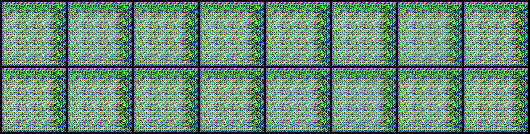

In [35]:
Image('./generated/generated-images-0001.png')

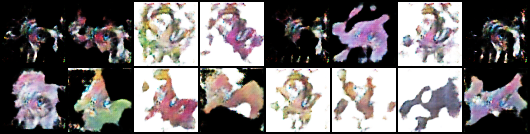

In [36]:
Image('./generated/generated-images-0200.png')

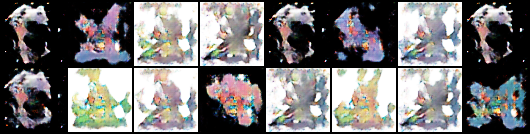

In [37]:
Image('./generated/generated-images-0400.png')

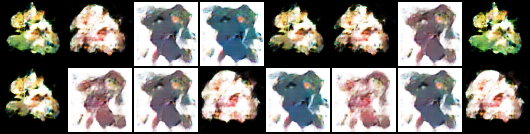

In [38]:
Image('./generated/generated-images-0600.png')

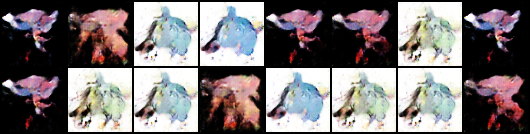

In [39]:
Image('./generated/generated-images-0800.png')

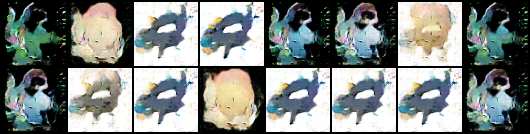

In [40]:
Image('./generated/generated-images-1000.png')

In [41]:
!zip -r generated.zip generated/

  adding: generated/ (stored 0%)
  adding: generated/generated-images-0317.png (deflated 0%)
  adding: generated/generated-images-0096.png (deflated 0%)
  adding: generated/generated-images-0557.png (deflated 0%)
  adding: generated/generated-images-0910.png (deflated 0%)
  adding: generated/generated-images-0108.png (deflated 0%)
  adding: generated/generated-images-0521.png (deflated 0%)
  adding: generated/generated-images-0835.png (deflated 0%)
  adding: generated/generated-images-0577.png (deflated 0%)
  adding: generated/generated-images-0289.png (deflated 0%)
  adding: generated/generated-images-0219.png (deflated 0%)
  adding: generated/generated-images-0560.png (deflated 0%)
  adding: generated/generated-images-0599.png (deflated 0%)
  adding: generated/generated-images-0522.png (deflated 0%)
  adding: generated/generated-images-0301.png (deflated 0%)
  adding: generated/generated-images-0733.png (deflated 0%)
  adding: generated/generated-images-0105.png (deflated 0%)
  addin